In [394]:
# Import necessary libraries and modules for the analysis

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from pathlib import Path
from warnings import simplefilter
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import cross_val_score 

In [395]:
# define function for symmetric mean absolute percentage error
def f_smape(y_true, y_pred):
    """
    Calculate symmetric mean absolute percentage error between two arrays.
    """
    denominator = np.abs(y_true) + np.abs(y_pred)
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 2.0 * np.mean(diff)

In [396]:
# Load data from an escel file named "final2.xlsx" and store it in a pandas dataframe named "data"
# You can download the file with this link: https://www.dropbox.com/scl/fi/gjq8dyzzrxnnu5qq4ha8u/final2.xlsx?dl=0&rlkey=ygfevro2nhsrdws0h9qim73f7

data = pd.read_excel('final2.xlsx')



In [397]:
# Display the first 5 rows of the data
data.head(5)

usage_date Product Family Region Zone Region_Zone  Sold QTY  Year  Month  \
0 2019-05-16        L1_cpus  Alpha    a     Alpha-a         0  2019      5   
1 2019-05-17        L1_cpus  Alpha    a     Alpha-a         0  2019      5   
2 2019-05-18        L1_cpus  Alpha    a     Alpha-a         0  2019      5   
3 2019-05-19        L1_cpus  Alpha    a     Alpha-a         0  2019      5   
4 2019-05-20        L1_cpus  Alpha    a     Alpha-a         0  2019      5   

   Weeknum Year_month Year_weeknum  serial_weeknum  serial_monthnum  
0       20     2019-5      2019-20              20                5  
1       20     2019-5      2019-20              20                5  
2       20     2019-5      2019-20              20                5  
3       21     2019-5      2019-21              21                5  
4       21     2019-5      2019-21              21                5

In [398]:
# Display the last 5 rows of the data
data.tail(5)

usage_date Product Family Region Zone Region_Zone  Sold QTY  Year  \
12995 2022-02-04        L1_cpus  Gamma    c     Gamma-c     15157  2022   
12996 2022-02-05        L1_cpus  Gamma    c     Gamma-c     14065  2022   
12997 2022-02-06        L1_cpus  Gamma    c     Gamma-c     14048  2022   
12998 2022-02-07        L1_cpus  Gamma    c     Gamma-c     13984  2022   
12999 2022-02-08        L1_cpus  Gamma    c     Gamma-c     14528  2022   

       Month  Weeknum Year_month Year_weeknum  serial_weeknum  serial_monthnum  
12995      2        6     2022-2       2022-6             165               38  
12996      2        6     2022-2       2022-6             165               38  
12997      2        7     2022-2       2022-7             166               38  
12998      2        7     2022-2       2022-7             166               38  
12999      2        7     2022-2       2022-7             166               38

In [399]:
# Generate descriptive statistics for the data
data.describe()

Sold QTY          Year         Month       Weeknum  serial_weeknum  \
count  13000.000000  13000.000000  13000.000000  13000.000000    13000.000000   
mean    8748.489462   2020.213000      6.820000     28.424000       92.713000   
std    13197.377689      0.840051      3.454058     15.037607       42.032565   
min        0.000000   2019.000000      1.000000      1.000000       20.000000   
25%     1048.000000   2020.000000      4.000000     16.000000       57.000000   
50%     4358.500000   2020.000000      7.000000     29.000000       92.500000   
75%     8403.250000   2021.000000     10.000000     41.000000      129.000000   
max    65520.000000   2022.000000     12.000000     53.000000      166.000000   

       serial_monthnum  
count     13000.000000  
mean         21.376000  
std           9.483646  
min           5.000000  
25%          13.000000  
50%          21.000000  
75%          30.000000  
max          38.000000

In [400]:
# Display the data types of each column in the data
data.dtypes

usage_date         datetime64[ns]
Product Family             object
Region                     object
Zone                       object
Region_Zone                object
Sold QTY                    int64
Year                        int64
Month                       int64
Weeknum                     int64
Year_month                 object
Year_weeknum               object
serial_weeknum              int64
serial_monthnum             int64
dtype: object

In [401]:
# Check for missing values in the data and generate summary statistics
data.isna().describe()

usage_date Product Family Region   Zone Region_Zone Sold QTY   Year  \
count       13000          13000  13000  13000       13000    13000  13000   
unique          1              1      1      1           1        1      1   
top         False          False  False  False       False    False  False   
freq        13000          13000  13000  13000       13000    13000  13000   

        Month Weeknum Year_month Year_weeknum serial_weeknum serial_monthnum  
count   13000   13000      13000        13000          13000           13000  
unique      1       1          1            1              1               1  
top     False   False      False        False          False           False  
freq    13000   13000      13000        13000          13000           13000

In [402]:
# Group the data by the 'Region_Zone' column and count the number of occurrences in each group
data.groupby(['Region_Zone'])['Region_Zone'].count()

Region_Zone
Alpha-a      1000
Alpha-b      1000
Beta-a       1000
Beta-b       1000
Beta-c       1000
Delta-a      1000
Delta-b      1000
Delta-c      1000
Epsilon-b    1000
Epsilon-d    1000
Gamma-a      1000
Gamma-b      1000
Gamma-c      1000
Name: Region_Zone, dtype: int64

In [403]:
# Sort the data by 'Region_Zone' and 'usage_date', and reset the index
data_time_series = data.sort_values(['Region_Zone','usage_date']).reset_index(drop=True)

In [404]:
# Display the contents of the data_time_series dataframe
data_time_series

usage_date Product Family Region Zone Region_Zone  Sold QTY  Year  \
0     2019-05-16        L1_cpus  Alpha    a     Alpha-a         0  2019   
1     2019-05-17        L1_cpus  Alpha    a     Alpha-a         0  2019   
2     2019-05-18        L1_cpus  Alpha    a     Alpha-a         0  2019   
3     2019-05-19        L1_cpus  Alpha    a     Alpha-a         0  2019   
4     2019-05-20        L1_cpus  Alpha    a     Alpha-a         0  2019   
...          ...            ...    ...  ...         ...       ...   ...   
12995 2022-02-04        L1_cpus  Gamma    c     Gamma-c     15157  2022   
12996 2022-02-05        L1_cpus  Gamma    c     Gamma-c     14065  2022   
12997 2022-02-06        L1_cpus  Gamma    c     Gamma-c     14048  2022   
12998 2022-02-07        L1_cpus  Gamma    c     Gamma-c     13984  2022   
12999 2022-02-08        L1_cpus  Gamma    c     Gamma-c     14528  2022   

       Month  Weeknum Year_month Year_weeknum  serial_weeknum  serial_monthnum  
0          5       20     2019-5      2019-20              20                5  
1          5       20     2019-5      2019-20              20                5  
2          5       20     2019-5      2019-20              20                5  
3          5       21     2019-5      2019-21              21                5  
4          5       21     2019-5      2019-21              21                5  
...      ...      ...        ...          ...             ...              ...  
12995      2        6     2022-2       2022-6             165               38  
12996      2        6     2022-2       2022-6             165               38  
12997      2        7     2022-2       2022-7             166               38  
12998      2        7     2022-2       2022-7             166               38  
12999      2        7     2022-2       2022-7             166               38  

[13000 rows x 13 columns]

In [405]:
# Extract the day and weekday information from the 'usage_date' column, create a lag variable, and drop missing values
data_time_series['day'] = data_time_series['usage_date'].dt.day
data_time_series['weekday'] = data_time_series['usage_date'].dt.weekday.astype("category")
data_time_series['Lag_1'] = data_time_series['Sold QTY'].shift(1)
data_time_series.dropna(inplace=True)
data_time_series=data_time_series.set_index('usage_date')

In [406]:
# Display the contents of the data_time_series dataframe after extracting day and weekday information, creating a lag variable, dropping missing values, and setting the index to 'usage_date'
data_time_series

Product Family Region Zone Region_Zone  Sold QTY  Year  Month  \
usage_date                                                                 
2019-05-17        L1_cpus  Alpha    a     Alpha-a         0  2019      5   
2019-05-18        L1_cpus  Alpha    a     Alpha-a         0  2019      5   
2019-05-19        L1_cpus  Alpha    a     Alpha-a         0  2019      5   
2019-05-20        L1_cpus  Alpha    a     Alpha-a         0  2019      5   
2019-05-21        L1_cpus  Alpha    a     Alpha-a         0  2019      5   
...                   ...    ...  ...         ...       ...   ...    ...   
2022-02-04        L1_cpus  Gamma    c     Gamma-c     15157  2022      2   
2022-02-05        L1_cpus  Gamma    c     Gamma-c     14065  2022      2   
2022-02-06        L1_cpus  Gamma    c     Gamma-c     14048  2022      2   
2022-02-07        L1_cpus  Gamma    c     Gamma-c     13984  2022      2   
2022-02-08        L1_cpus  Gamma    c     Gamma-c     14528  2022      2   

            Weeknum Year_month Year_weeknum  serial_weeknum  serial_monthnum  \
usage_date                                                                     
2019-05-17       20     2019-5      2019-20              20                5   
2019-05-18       20     2019-5      2019-20              20                5   
2019-05-19       21     2019-5      2019-21              21                5   
2019-05-20       21     2019-5      2019-21              21                5   
2019-05-21       21     2019-5      2019-21              21                5   
...             ...        ...          ...             ...              ...   
2022-02-04        6     2022-2       2022-6             165               38   
2022-02-05        6     2022-2       2022-6             165               38   
2022-02-06        7     2022-2       2022-7             166               38   
2022-02-07        7     2022-2       2022-7             166               38   
2022-02-08        7     2022-2       2022-7             166               38   

            day weekday    Lag_1  
usage_date                        
2019-05-17   17       4      0.0  
2019-05-18   18       5      0.0  
2019-05-19   19       6      0.0  
2019-05-20   20       0      0.0  
2019-05-21   21       1      0.0  
...         ...     ...      ...  
2022-02-04    4       4  18416.0  
2022-02-05    5       5  15157.0  
2022-02-06    6       6  14065.0  
2022-02-07    7       0  14048.0  
2022-02-08    8       1  13984.0  

[12999 rows x 15 columns]

In [407]:
# Copy the 'Sold QTY' column of the 'data_time_series' dataframe to a new variable 'y'
y=data_time_series['Sold QTY'].copy()
##Create a fourier feature of order 4 for the monthly seasons.
#fourier = CalendarFourier(freq='M', order=4)

#DeterministicProcess adds indicators for the weekly seasons
# Create a DeterministicProcess object 'dp' with a constant term, linear trend, and weekly seasonality, using the 'y' index for the dates
# Generate a set of deterministic regressors 'X' based on the 'dp' object, for in-sample use
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    period=7,
    seasonal=True,
#    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

In [408]:
# Display X 
X

const    trend  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)
usage_date                                                                
2019-05-17    1.0      1.0     0.0     0.0     0.0     0.0     0.0     0.0
2019-05-18    1.0      2.0     1.0     0.0     0.0     0.0     0.0     0.0
2019-05-19    1.0      3.0     0.0     1.0     0.0     0.0     0.0     0.0
2019-05-20    1.0      4.0     0.0     0.0     1.0     0.0     0.0     0.0
2019-05-21    1.0      5.0     0.0     0.0     0.0     1.0     0.0     0.0
...           ...      ...     ...     ...     ...     ...     ...     ...
2022-02-04    1.0  12995.0     0.0     1.0     0.0     0.0     0.0     0.0
2022-02-05    1.0  12996.0     0.0     0.0     1.0     0.0     0.0     0.0
2022-02-06    1.0  12997.0     0.0     0.0     0.0     1.0     0.0     0.0
2022-02-07    1.0  12998.0     0.0     0.0     0.0     0.0     1.0     0.0
2022-02-08    1.0  12999.0     0.0     0.0     0.0     0.0     0.0     1.0

[12999 rows x 8 columns]

In [409]:
# This code merges the X data (deterministic regressors) into the data_time_series DataFrame. The merge is performed using the time index of the two datasets, with the left_index=True and right_index=True parameters. After the merge, the resulting data_time_series DataFrame will include both the original time series data as well as the deterministic regressors, allowing them to be used together in modeling and analysis.
data_time_series=pd.concat([data_time_series, X], axis=1)

In [410]:
# This code returns the data types of each column in the data_time_series DataFrame.
data_time_series.dtypes

Product Family       object
Region               object
Zone                 object
Region_Zone          object
Sold QTY              int64
Year                  int64
Month                 int64
Weeknum               int64
Year_month           object
Year_weeknum         object
serial_weeknum        int64
serial_monthnum       int64
day                   int64
weekday            category
Lag_1               float64
const               float64
trend               float64
s(2,7)              float64
s(3,7)              float64
s(4,7)              float64
s(5,7)              float64
s(6,7)              float64
s(7,7)              float64
dtype: object

In [411]:
#This code drops several columns from the data_time_series DataFrame using the drop method. 
data_time_series = data_time_series.drop(columns =['Product Family','Region','Zone','Year_month','Year_weeknum','serial_weeknum','serial_monthnum'] )

In [412]:
#Display data_time_series
data_time_series

Region_Zone  Sold QTY  Year  Month  Weeknum  day weekday    Lag_1  \
usage_date                                                                     
2019-05-17     Alpha-a         0  2019      5       20   17       4      0.0   
2019-05-18     Alpha-a         0  2019      5       20   18       5      0.0   
2019-05-19     Alpha-a         0  2019      5       21   19       6      0.0   
2019-05-20     Alpha-a         0  2019      5       21   20       0      0.0   
2019-05-21     Alpha-a         0  2019      5       21   21       1      0.0   
...                ...       ...   ...    ...      ...  ...     ...      ...   
2022-02-04     Gamma-c     15157  2022      2        6    4       4  18416.0   
2022-02-05     Gamma-c     14065  2022      2        6    5       5  15157.0   
2022-02-06     Gamma-c     14048  2022      2        7    6       6  14065.0   
2022-02-07     Gamma-c     13984  2022      2        7    7       0  14048.0   
2022-02-08     Gamma-c     14528  2022      2        7    8       1  13984.0   

            const    trend  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  
usage_date                                                                  
2019-05-17    1.0      1.0     0.0     0.0     0.0     0.0     0.0     0.0  
2019-05-18    1.0      2.0     1.0     0.0     0.0     0.0     0.0     0.0  
2019-05-19    1.0      3.0     0.0     1.0     0.0     0.0     0.0     0.0  
2019-05-20    1.0      4.0     0.0     0.0     1.0     0.0     0.0     0.0  
2019-05-21    1.0      5.0     0.0     0.0     0.0     1.0     0.0     0.0  
...           ...      ...     ...     ...     ...     ...     ...     ...  
2022-02-04    1.0  12995.0     0.0     1.0     0.0     0.0     0.0     0.0  
2022-02-05    1.0  12996.0     0.0     0.0     1.0     0.0     0.0     0.0  
2022-02-06    1.0  12997.0     0.0     0.0     0.0     1.0     0.0     0.0  
2022-02-07    1.0  12998.0     0.0     0.0     0.0     0.0     1.0     0.0  
2022-02-08    1.0  12999.0     0.0     0.0     0.0     0.0     0.0     1.0  

[12999 rows x 16 columns]

In [413]:
# This code returns an array of unique values from the Region_Zone column of the data_time_series DataFrame using the unique() method.
data_time_series['Region_Zone'].unique()

array(['Alpha-a', 'Alpha-b', 'Beta-a', 'Beta-b', 'Beta-c', 'Delta-a',
       'Delta-b', 'Delta-c', 'Epsilon-b', 'Epsilon-d', 'Gamma-a',
       'Gamma-b', 'Gamma-c'], dtype=object)

In [414]:
# Create separate dataframes for each unique value in the 'Region_Zone' column
# Each dataframe is named after its unique value

region_data_frames = []
region_names = []
for region_name, df in data_time_series.groupby('Region_Zone'):
  region_data_frames.append(df)
  region_names.append(region_name)
  
Alpha_a=data_time_series[data_time_series['Region_Zone']=='Alpha-a']
Alpha_b=data_time_series[data_time_series['Region_Zone']=='Alpha-b']
Beta_a=data_time_series[data_time_series['Region_Zone']=='Beta-a']
Beta_b=data_time_series[data_time_series['Region_Zone']=='Beta-b']
Beta_c=data_time_series[data_time_series['Region_Zone']=='Beta-c']
Delta_a=data_time_series[data_time_series['Region_Zone']=='Delta-a']
Delta_b=data_time_series[data_time_series['Region_Zone']=='Delta-b']
Delta_c=data_time_series[data_time_series['Region_Zone']=='Delta-c']
Epsilon_b=data_time_series[data_time_series['Region_Zone']=='Epsilon-b']
Epsilon_d=data_time_series[data_time_series['Region_Zone']=='Epsilon-d']
Gamma_a=data_time_series[data_time_series['Region_Zone']=='Gamma-a']
Gamma_b=data_time_series[data_time_series['Region_Zone']=='Gamma-b']
Gamma_c=data_time_series[data_time_series['Region_Zone']=='Gamma-c']

In [415]:
# This code creates a list of all the column names in the data_time_series DataFrame that have data type category. 
categorical_cols = [cname for cname in data_time_series.select_dtypes('category')]

In [416]:
# Building the pipeline
from sklearn.pipeline import Pipeline # --> DONE UPFRONT (see top section "Setting Up the Workspace")
from sklearn.impute import SimpleImputer # --> DONE UPFRONT (see top section "Setting Up the Workspace")
from sklearn.preprocessing import StandardScaler # --> DONE UPFRONT (see top section "Setting Up the Workspace")
from sklearn.preprocessing import OneHotEncoder # --> DONE UPFRONT (see top section "Setting Up the Workspace")
from sklearn.compose import ColumnTransformer # --> DONE UPFRONT (see top section "Setting Up the Workspace")

# Preprocessing for numerical data
#numerical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='constant')),
#    ('scaler', StandardScaler())
#])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='error', sparse=False))
])
    # The Pipeline() function is like a railway track with a list of different stations (steps)
    # Each step is a tuple declaring the name of the step and then the function to apply

categorical_transformer

Pipeline(steps=[('onehot', OneHotEncoder(sparse=False))])

In [417]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
#        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ], remainder='passthrough') 
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(sparse=False))]),
                                 ['weekday'])])

In [455]:
# display pipeline
model = LinearRegression()
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])
                            # Here the Pipeline() function is again like a railway track, with a higer level list of different stations (steps)
                            # Each step is a tuple declaring the name of the step and then the function to apply
my_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['weekday'])])),
                ('model', LinearRegression())])

In [456]:
model = BoostedHybrid(
      model_1=LinearRegression(),
      model_2=RandomForestRegressor(),
  )
my_pipeline2 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])
                            # Here the Pipeline() function is again like a railway track, with a higer level list of different stations (steps)
                            # Each step is a tuple declaring the name of the step and then the function to apply
my_pipeline2

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['weekday'])])),
                ('model', <__main__.BoostedHybrid object at 0x7f5f6602f070>)])

In [419]:
# This code is grouping the data by the usage_date column and calculating the sum of each numerical column, except for Year, Month, Weeknum, day, and Lag_1
total_data1 = data_time_series.groupby(['usage_date']).sum().drop(columns = ['Year','Month','Weeknum','day','Lag_1'])

<ipython-input-419-0d57473735cd>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_data1 = data_time_series.groupby(['usage_date']).sum().drop(columns = ['Year','Month','Weeknum','day','Lag_1'])


In [420]:
# Display total_data1
total_data1

Sold QTY  const    trend  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  \
usage_date                                                                     
2019-05-16     38512   12.0  78000.0     2.0     2.0     2.0     2.0     2.0   
2019-05-17     34966   13.0  78013.0     1.0     2.0     2.0     2.0     2.0   
2019-05-18     35927   13.0  78026.0     2.0     1.0     2.0     2.0     2.0   
2019-05-19     28220   13.0  78039.0     2.0     2.0     1.0     2.0     2.0   
2019-05-20     36325   13.0  78052.0     2.0     2.0     2.0     1.0     2.0   
...              ...    ...      ...     ...     ...     ...     ...     ...   
2022-02-04    209045   13.0  90935.0     1.0     2.0     2.0     2.0     2.0   
2022-02-05    205109   13.0  90948.0     2.0     1.0     2.0     2.0     2.0   
2022-02-06    205927   13.0  90961.0     2.0     2.0     1.0     2.0     2.0   
2022-02-07    206537   13.0  90974.0     2.0     2.0     2.0     1.0     2.0   
2022-02-08    208090   13.0  90987.0     2.0     2.0     2.0     2.0     1.0   

            s(7,7)  
usage_date          
2019-05-16     1.0  
2019-05-17     2.0  
2019-05-18     2.0  
2019-05-19     2.0  
2019-05-20     2.0  
...            ...  
2022-02-04     2.0  
2022-02-05     2.0  
2022-02-06     2.0  
2022-02-07     2.0  
2022-02-08     2.0  

[1000 rows x 9 columns]

<Axes: xlabel='usage_date'>

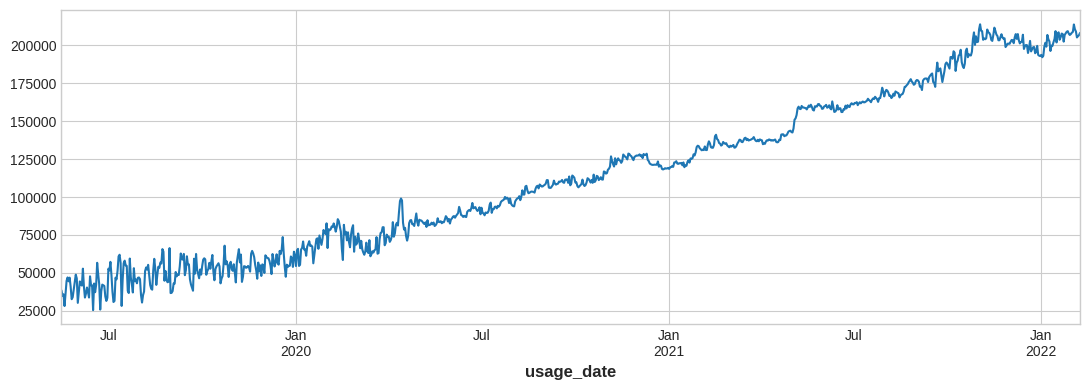

In [421]:
# visualize total_data1
total_data1['Sold QTY'].plot()

In [422]:
# Check unique Region_Zones
data['Region_Zone'].unique()

array(['Alpha-a', 'Alpha-b', 'Beta-a', 'Beta-b', 'Beta-c', 'Delta-a',
       'Delta-b', 'Delta-c', 'Epsilon-b', 'Epsilon-d', 'Gamma-a',
       'Gamma-b', 'Gamma-c'], dtype=object)

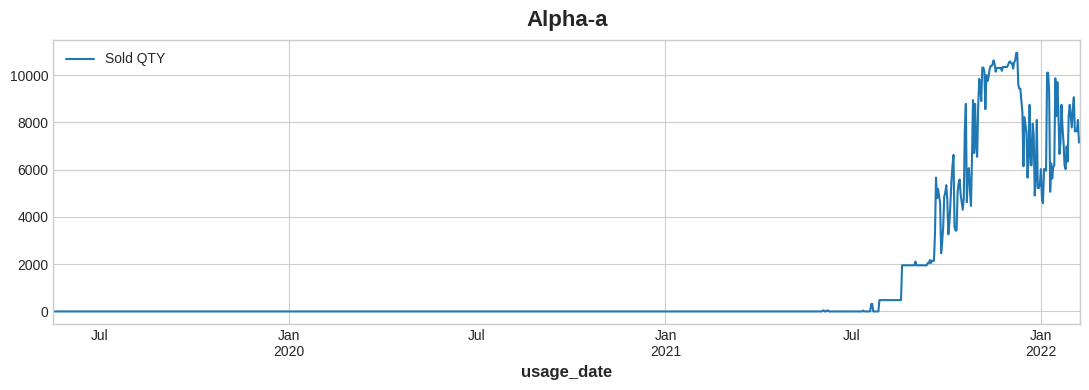

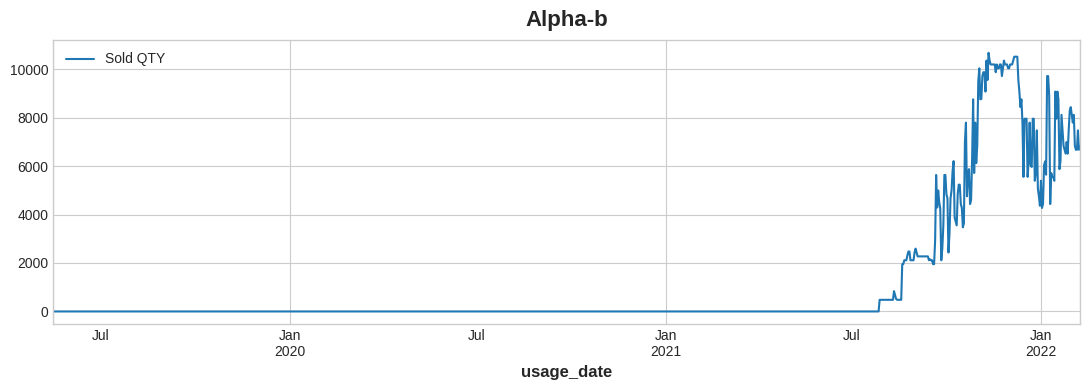

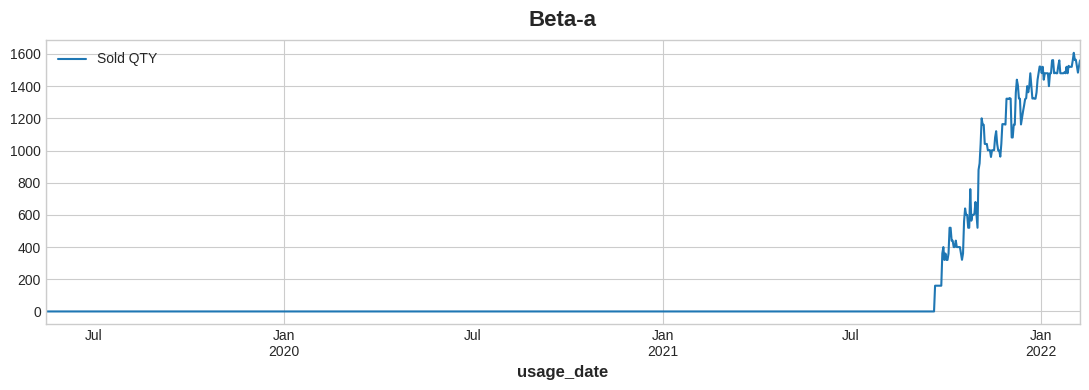

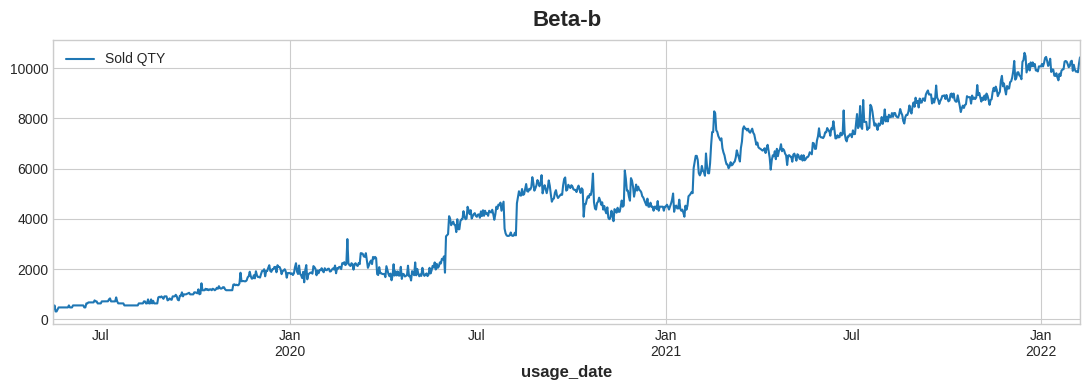

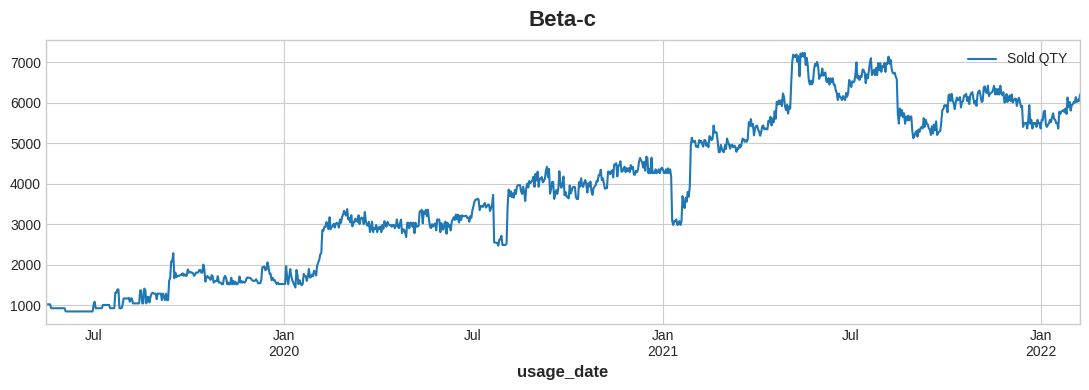

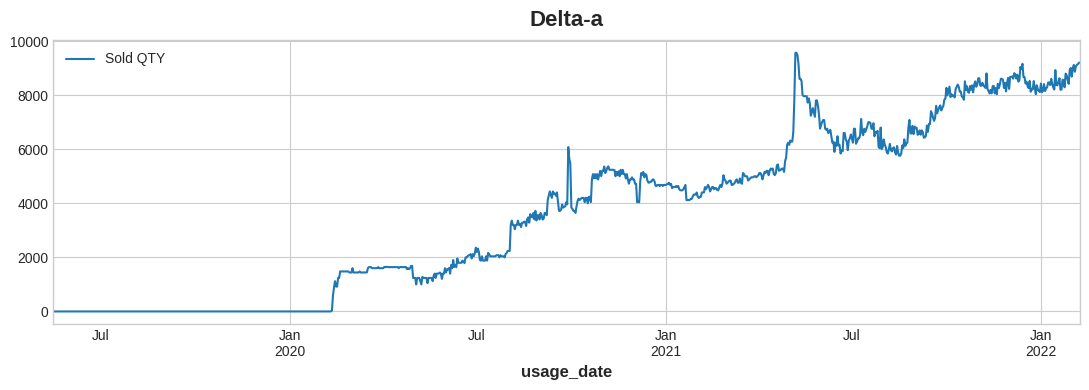

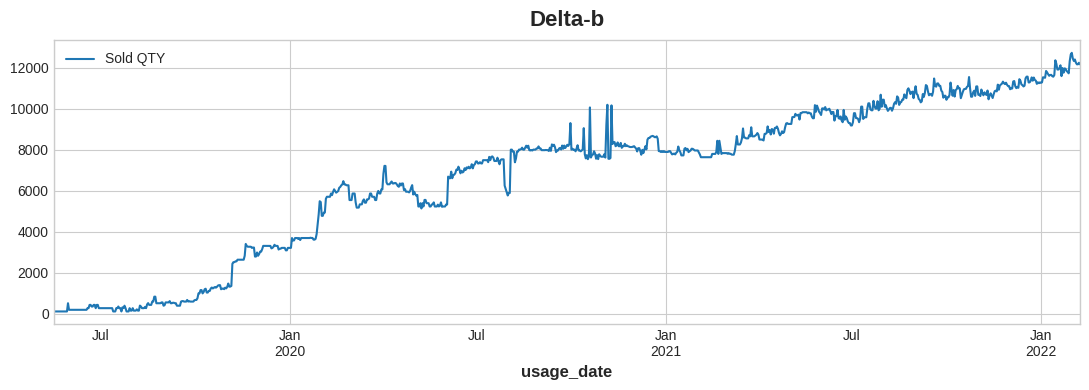

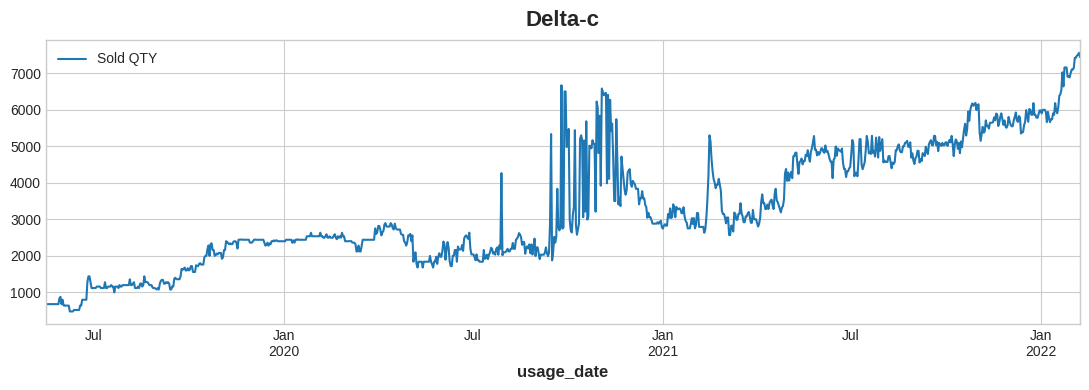

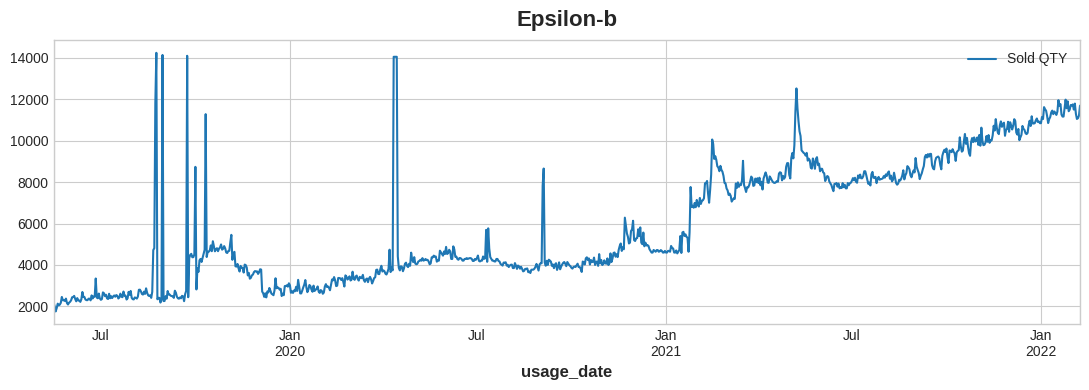

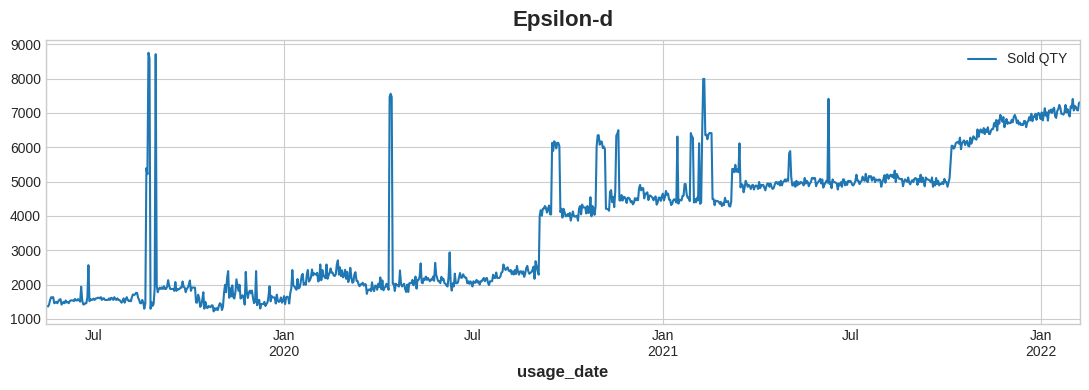

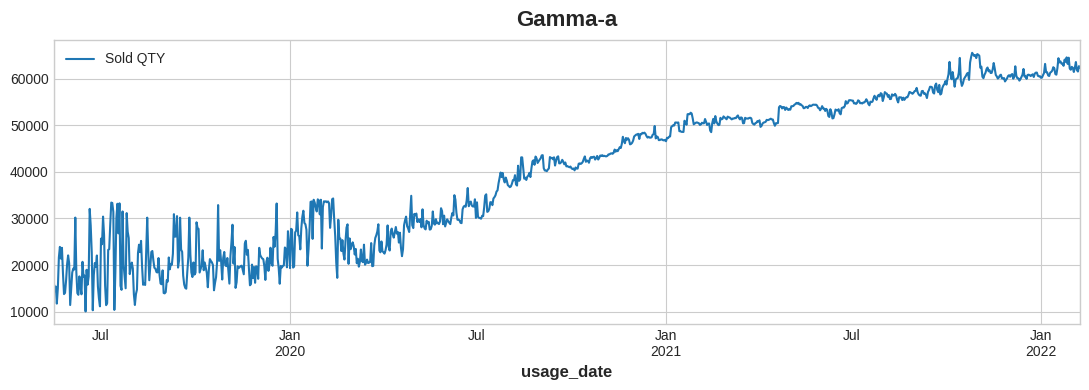

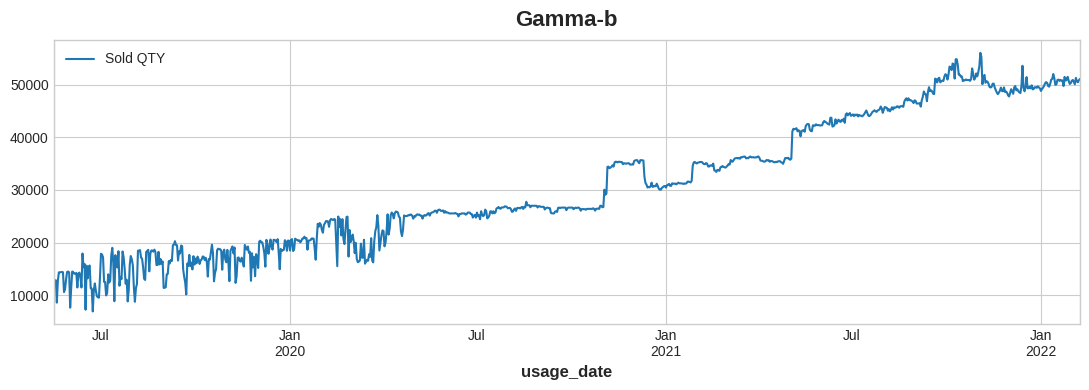

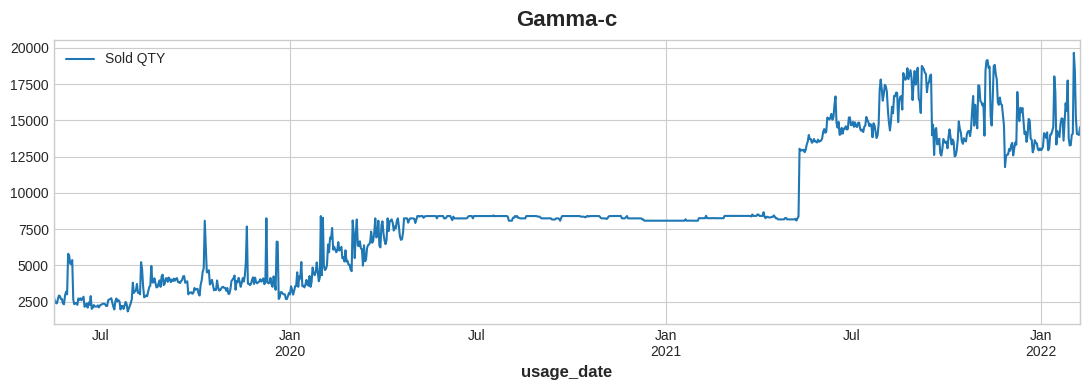

In [423]:
# visualize each single region_zone
for i in data_time_series.Region_Zone.unique():
  data=data_time_series[data_time_series['Region_Zone']==i]
  data[['Sold QTY']].plot(title= i)

In [424]:
# Define plot_periodogram function
def plot_periodogram(ts, detrend='linear', ax=None, name=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(frequencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=45,
        ha='right'
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    if name == None:
        ax.set_title("Periodogram")
    else:
        ax.set_title(name)
    return ax


In [425]:
# Check agian list of region_zones
data_time_series.Region_Zone.unique()

array(['Alpha-a', 'Alpha-b', 'Beta-a', 'Beta-b', 'Beta-c', 'Delta-a',
       'Delta-b', 'Delta-c', 'Epsilon-b', 'Epsilon-d', 'Gamma-a',
       'Gamma-b', 'Gamma-c'], dtype=object)

<ipython-input-424-6eaca160abb4>:4: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
<ipython-input-424-6eaca160abb4>:4: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
<ipython-input-424-6eaca160abb4>:4: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
<ipython-input-424-6eaca160abb4>:4: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
<ipython-input-424-6eaca160abb4>:4: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = 

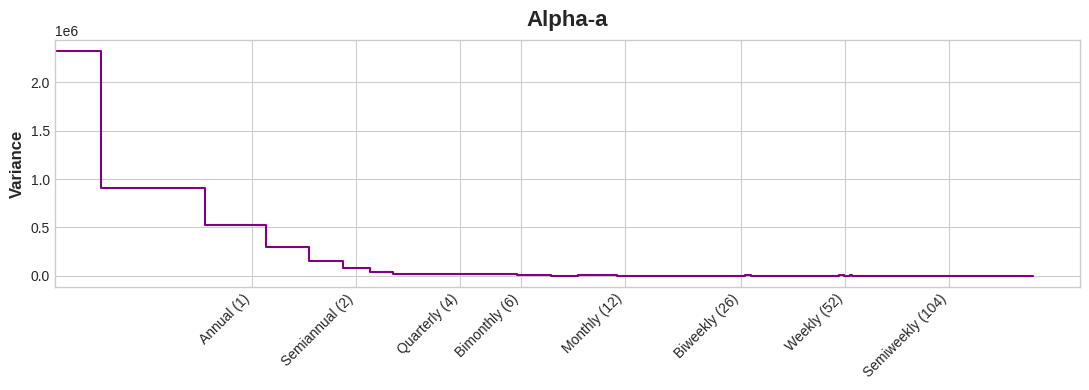

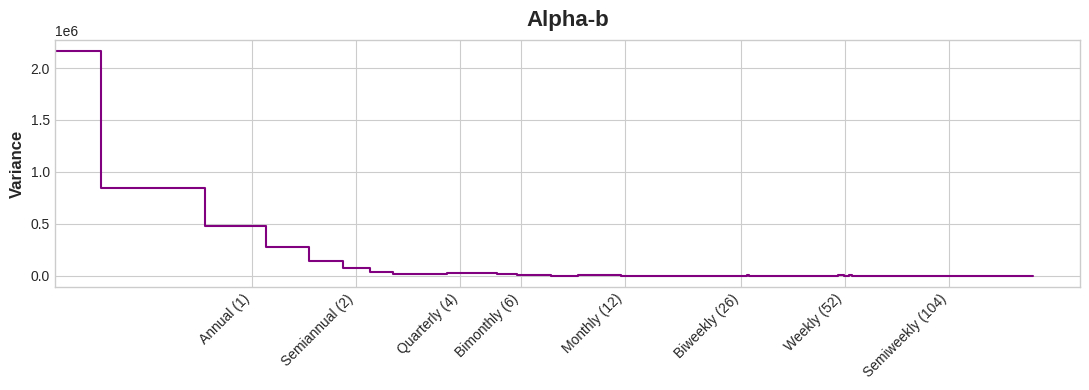

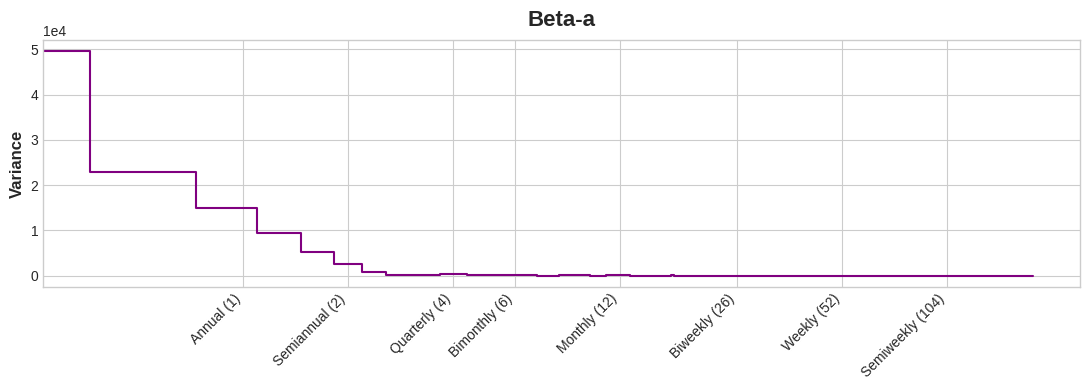

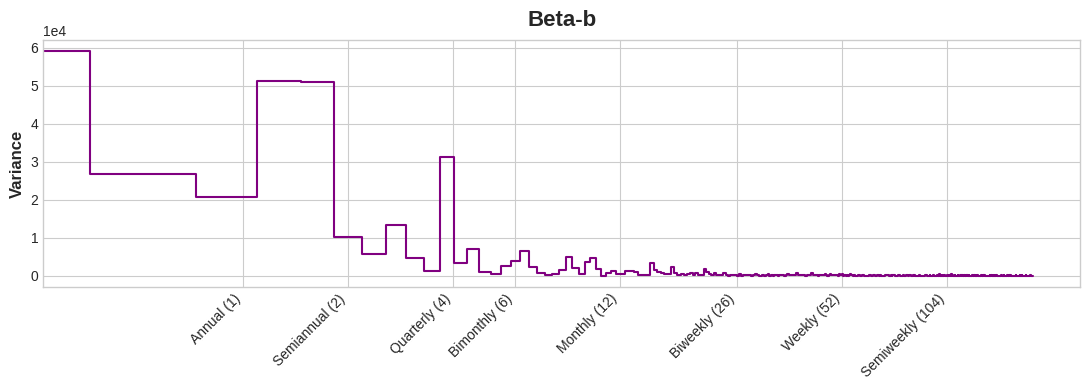

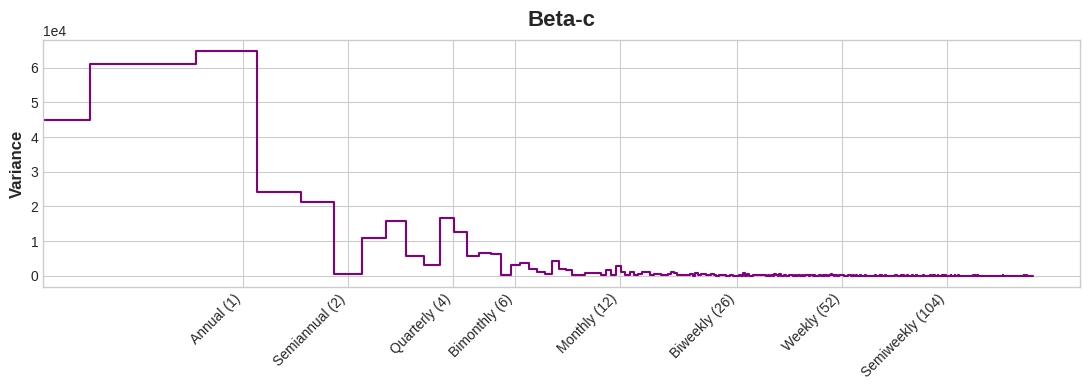

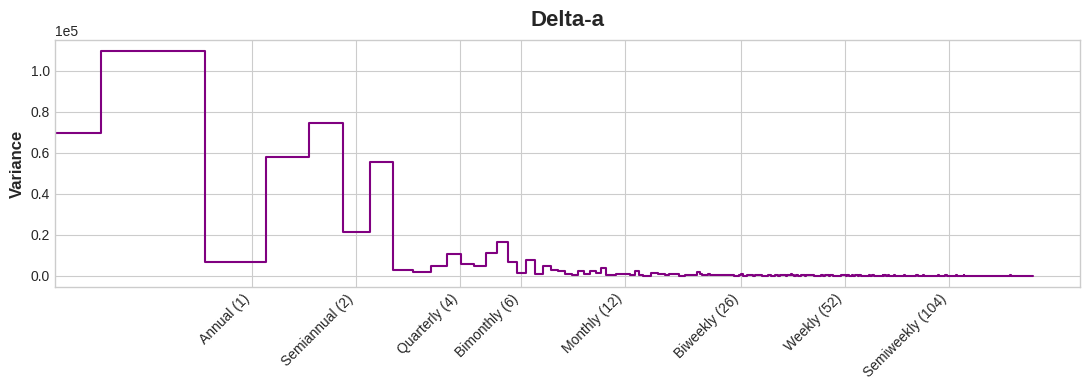

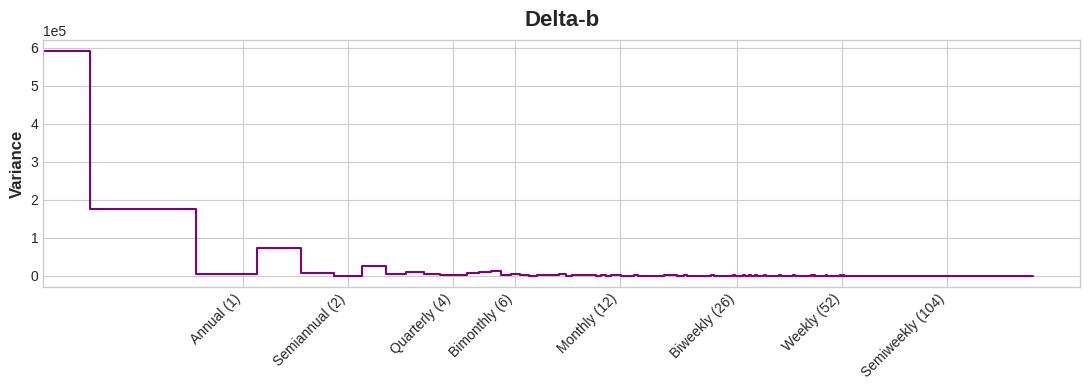

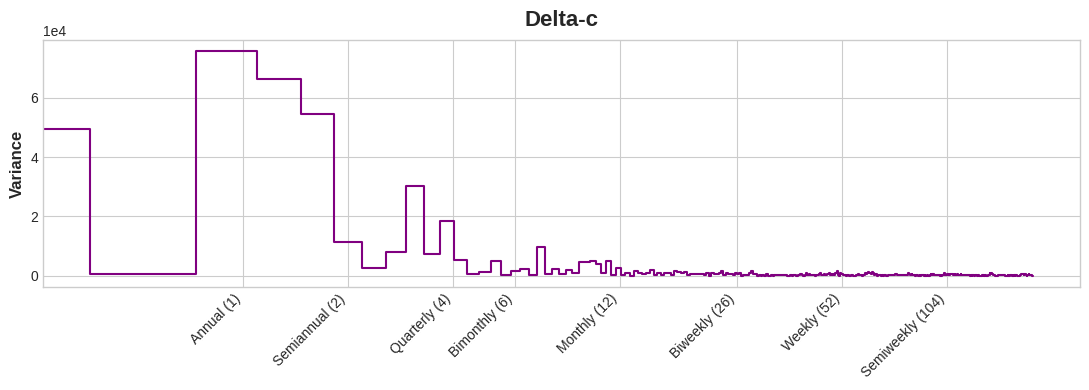

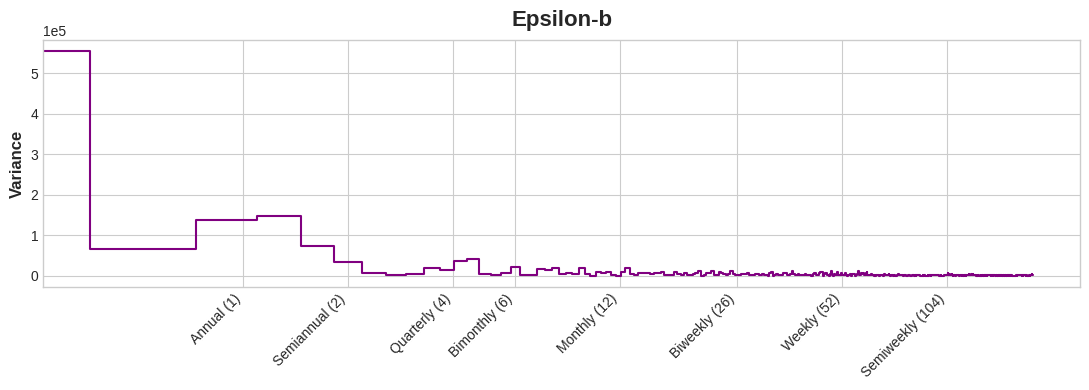

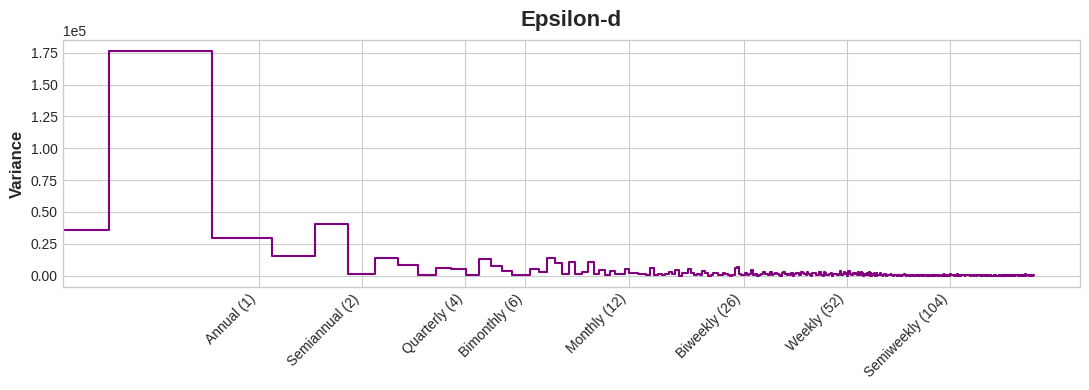

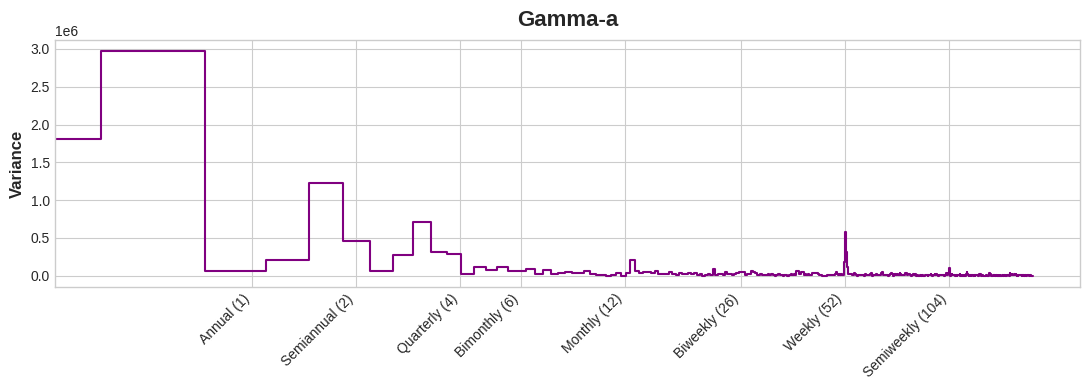

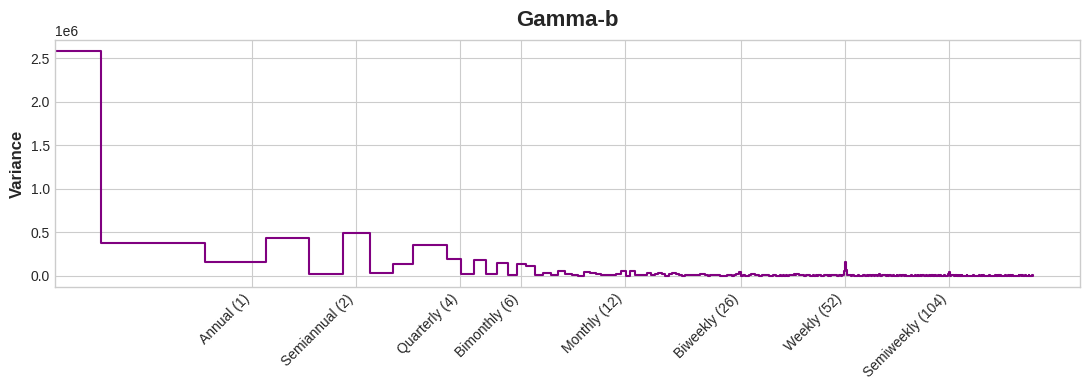

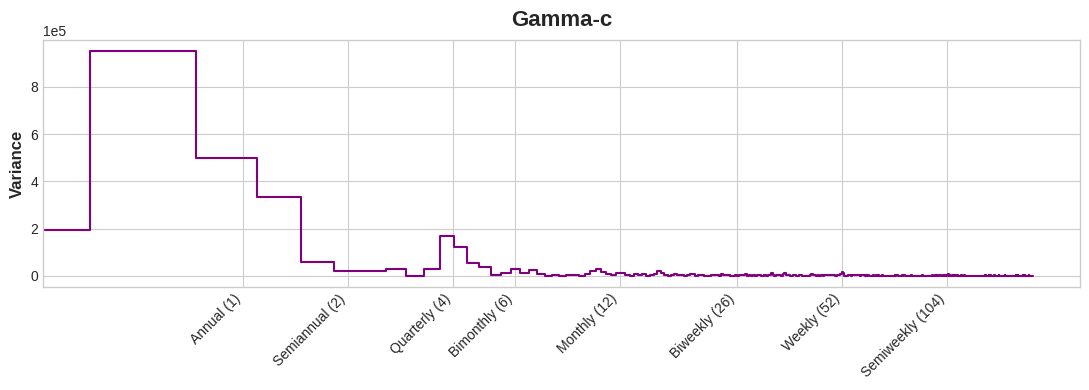

In [426]:
# plot_periodogram for every single region_zone
for i in data_time_series.Region_Zone.unique():
  plot_periodogram(data_time_series[data_time_series['Region_Zone']==i][['Sold QTY']]['Sold QTY'],name= i)

results for Alpha-a


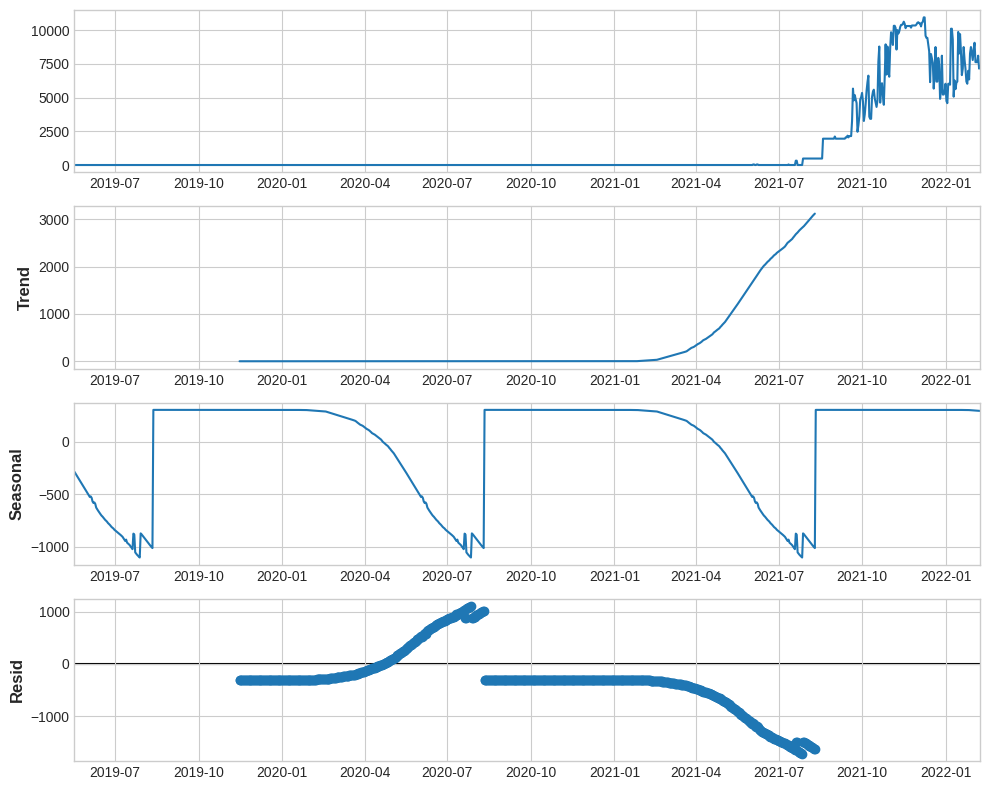

results for Alpha-b


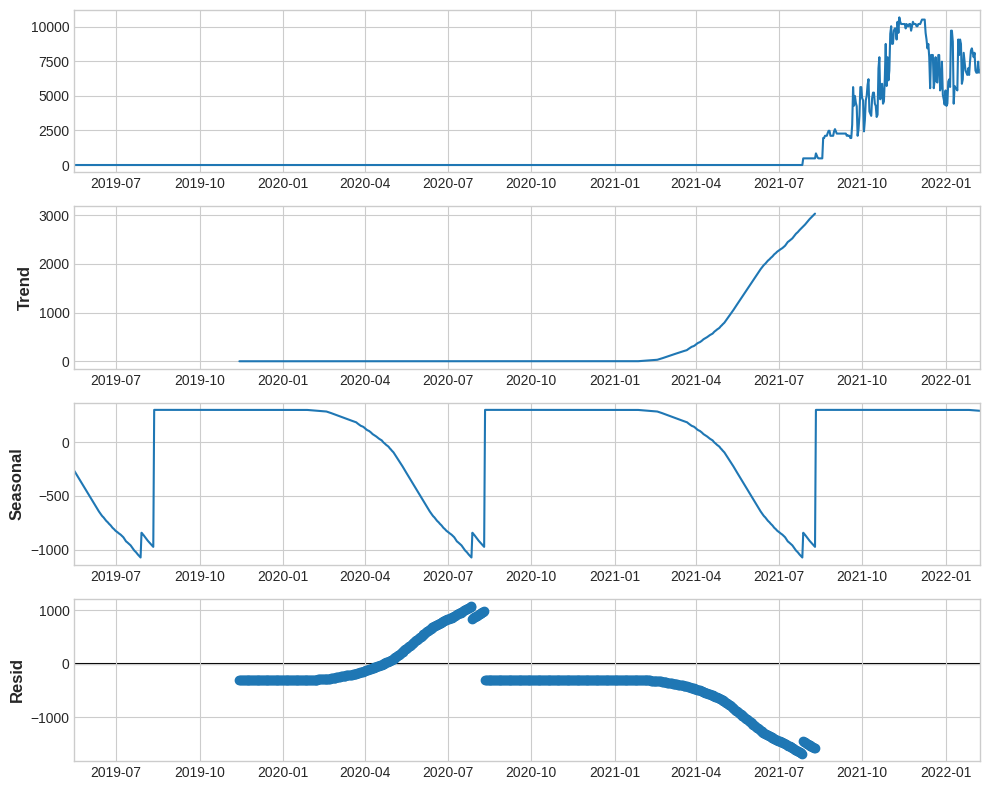

results for Beta-a


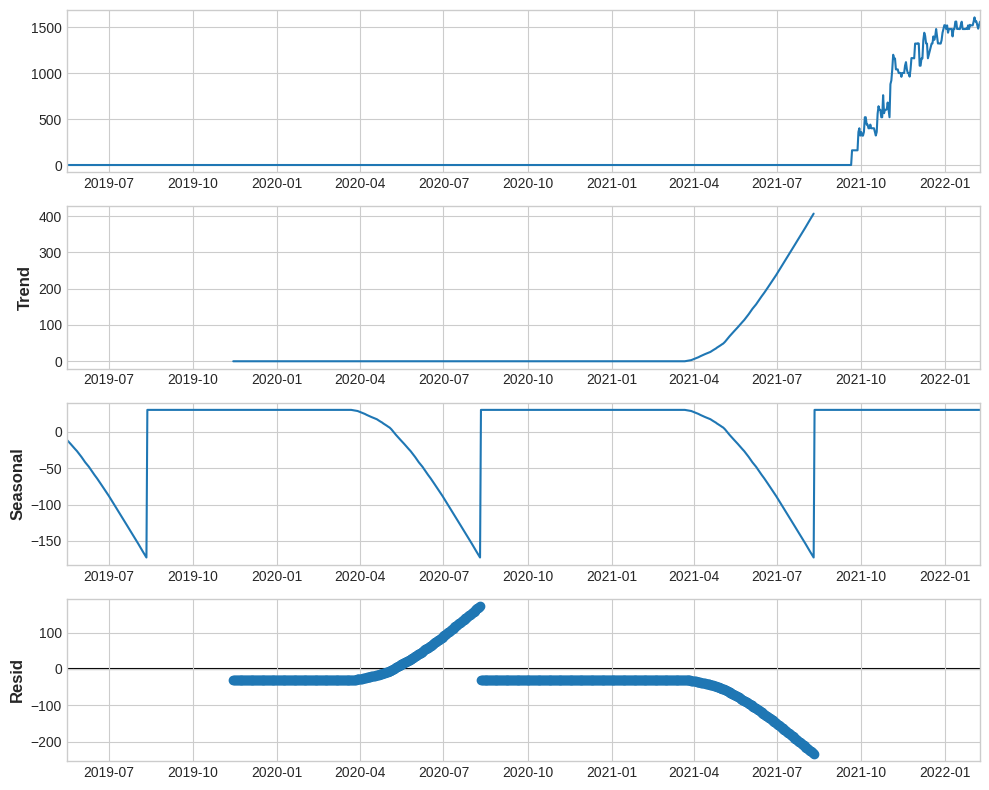

results for Beta-b


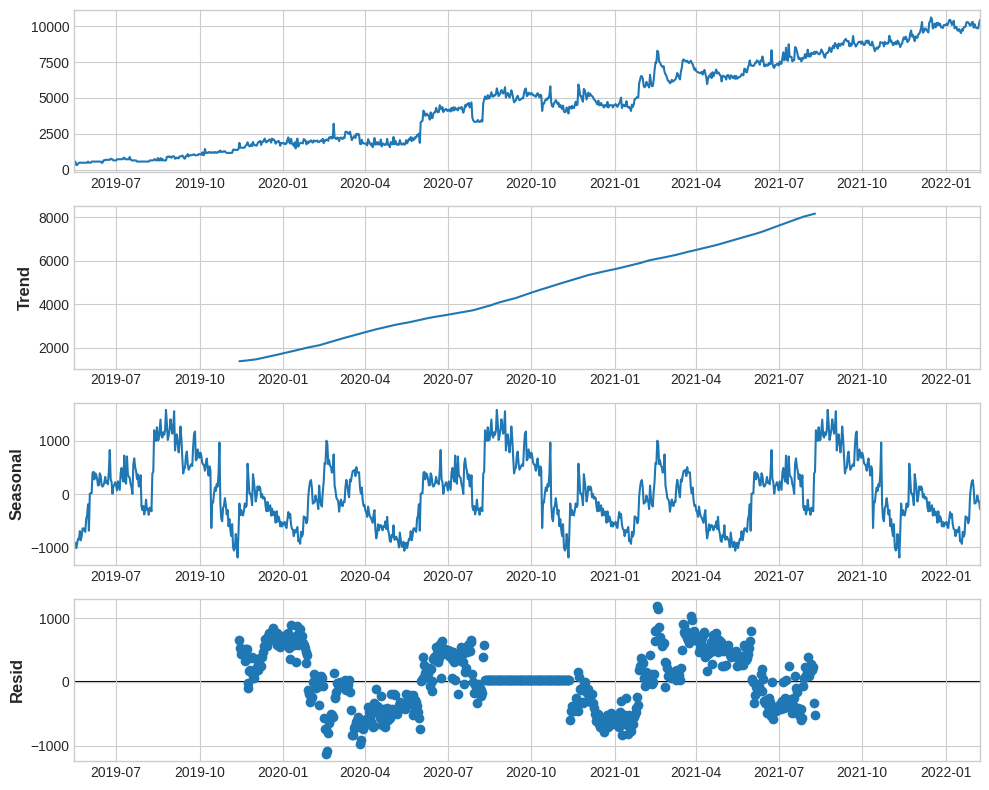

results for Beta-c


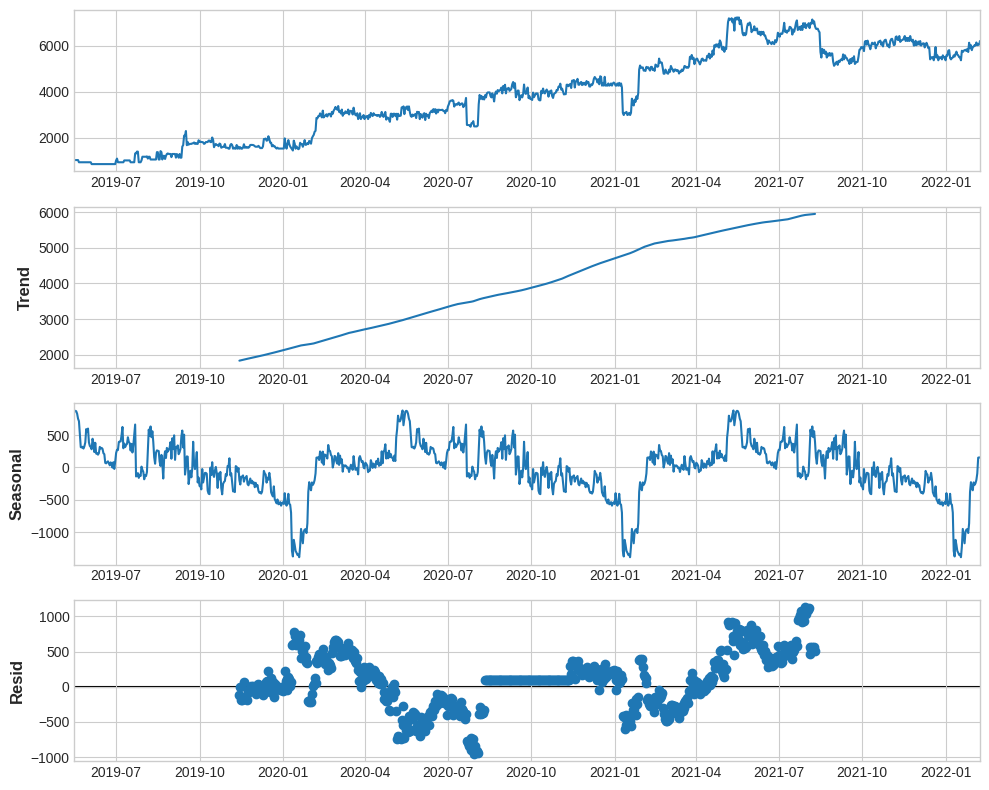

results for Delta-a


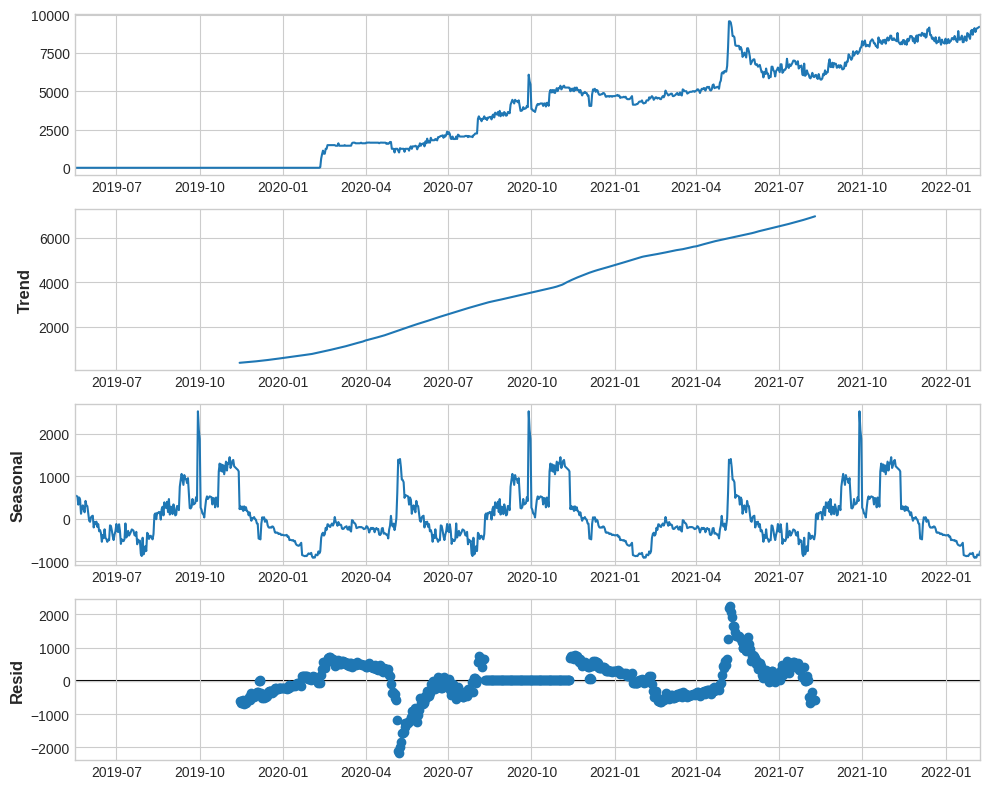

results for Delta-b


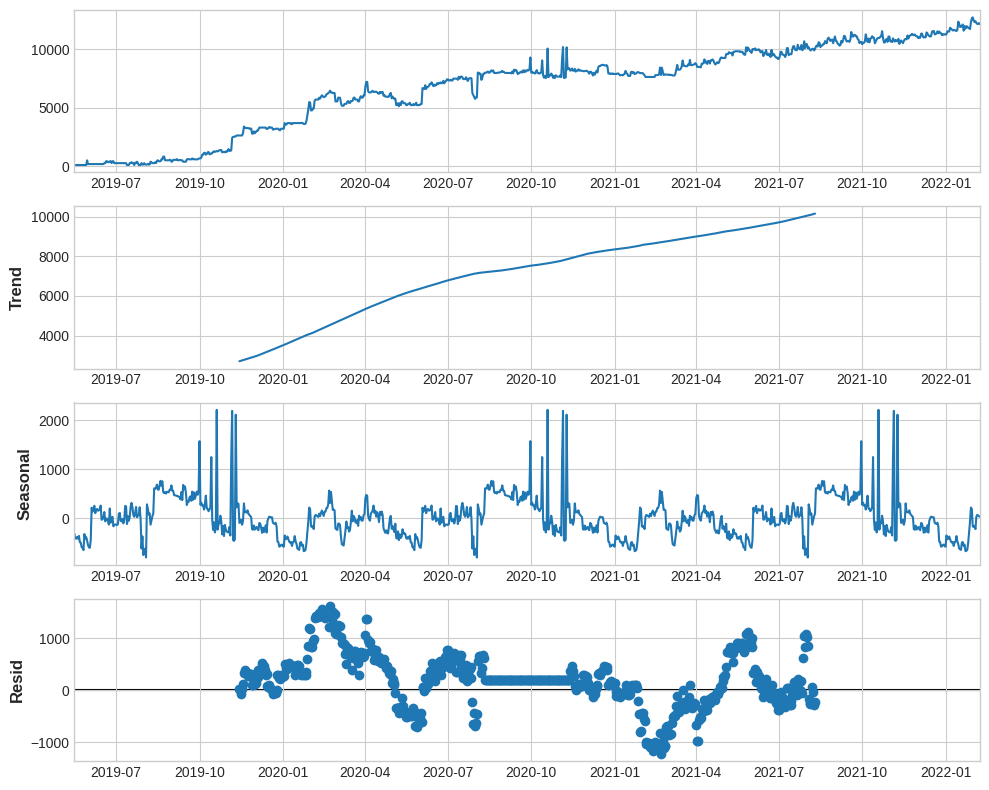

results for Delta-c


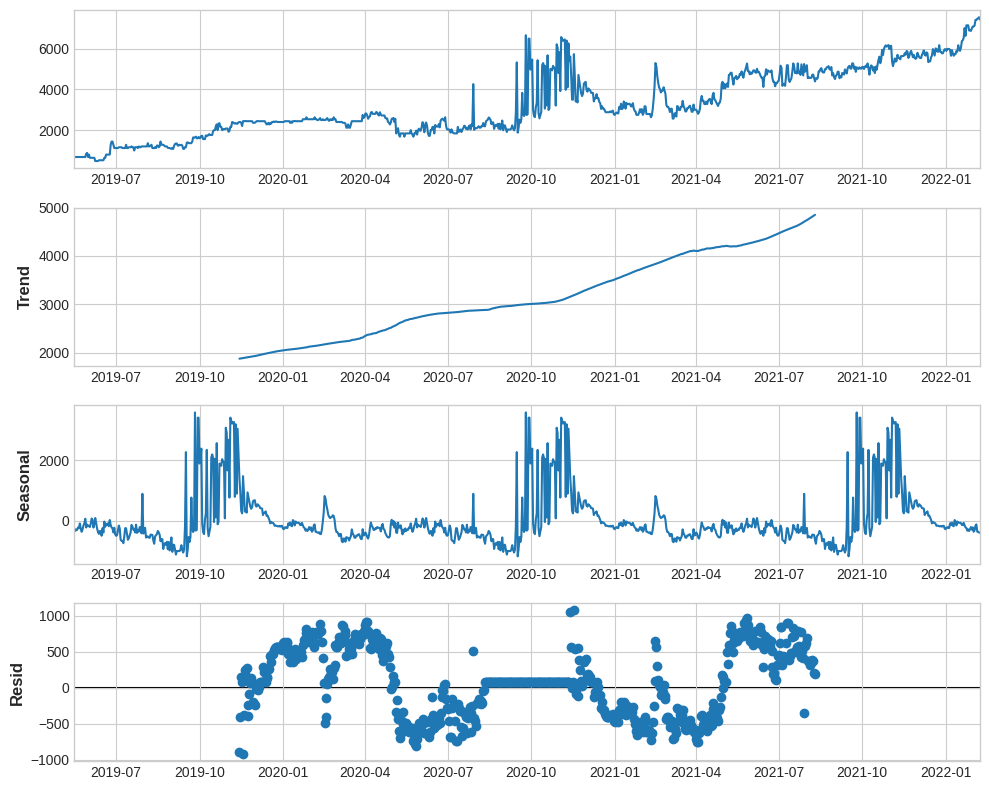

results for Epsilon-b


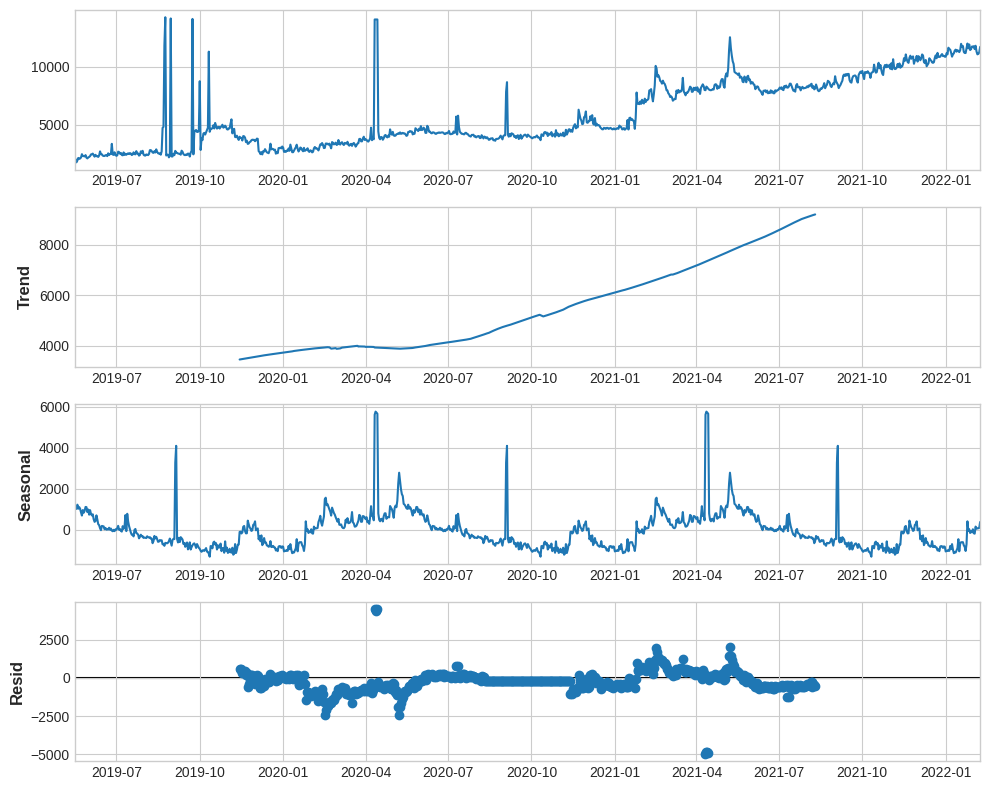

results for Epsilon-d


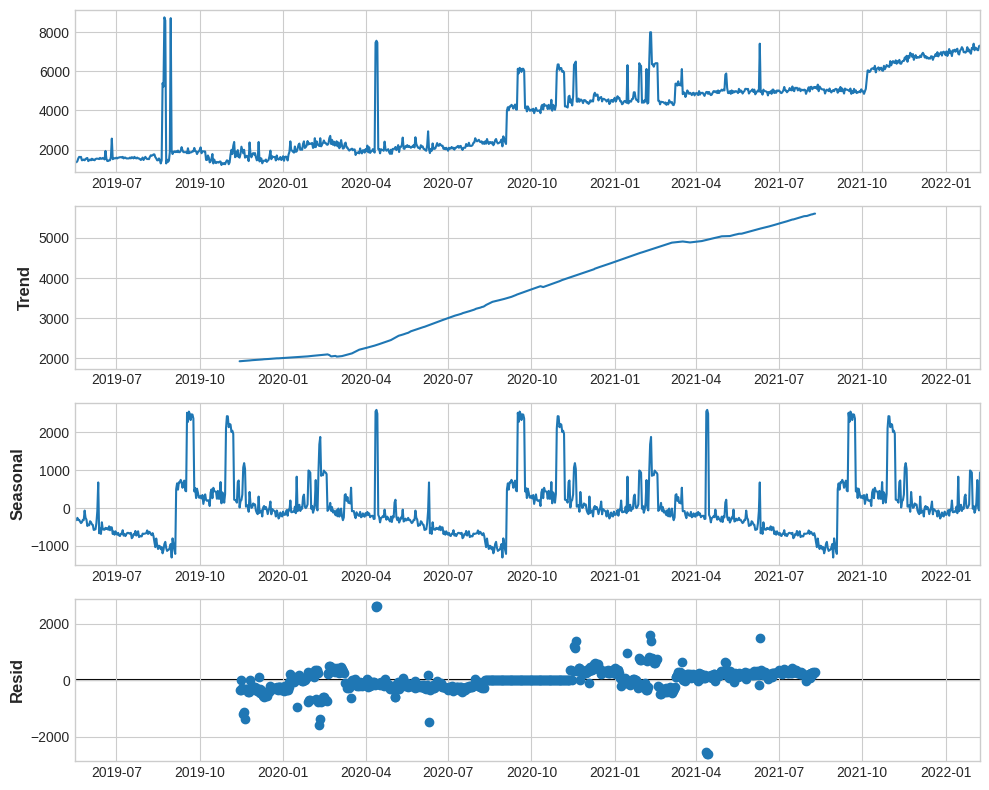

results for Gamma-a


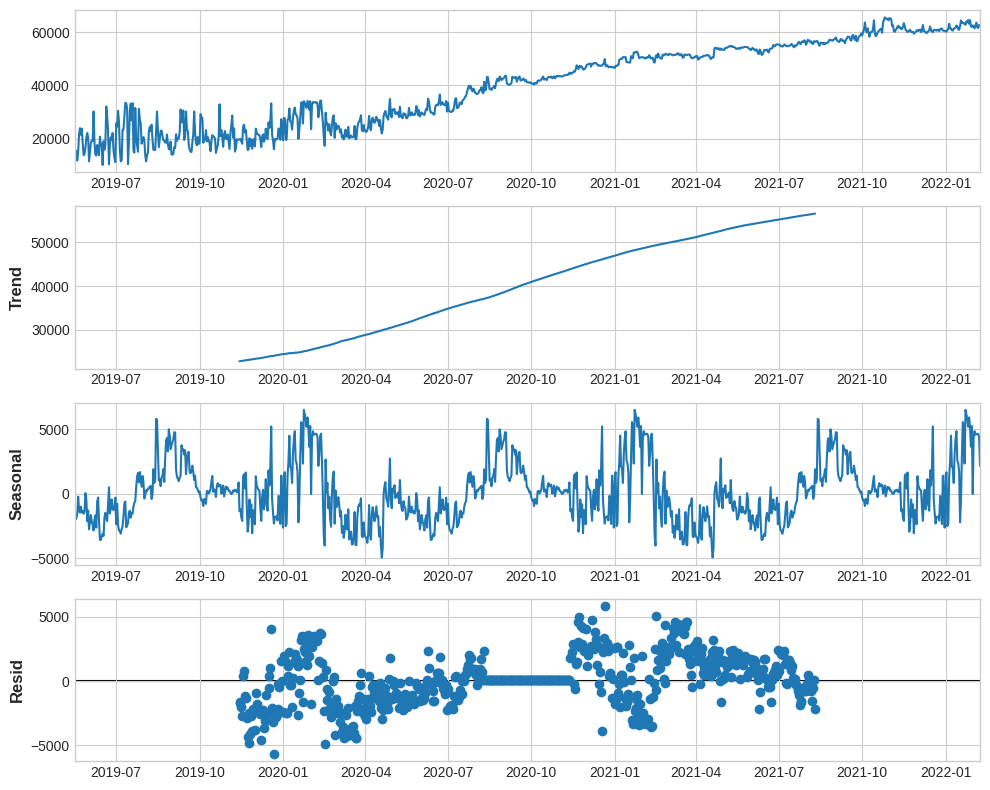

results for Gamma-b


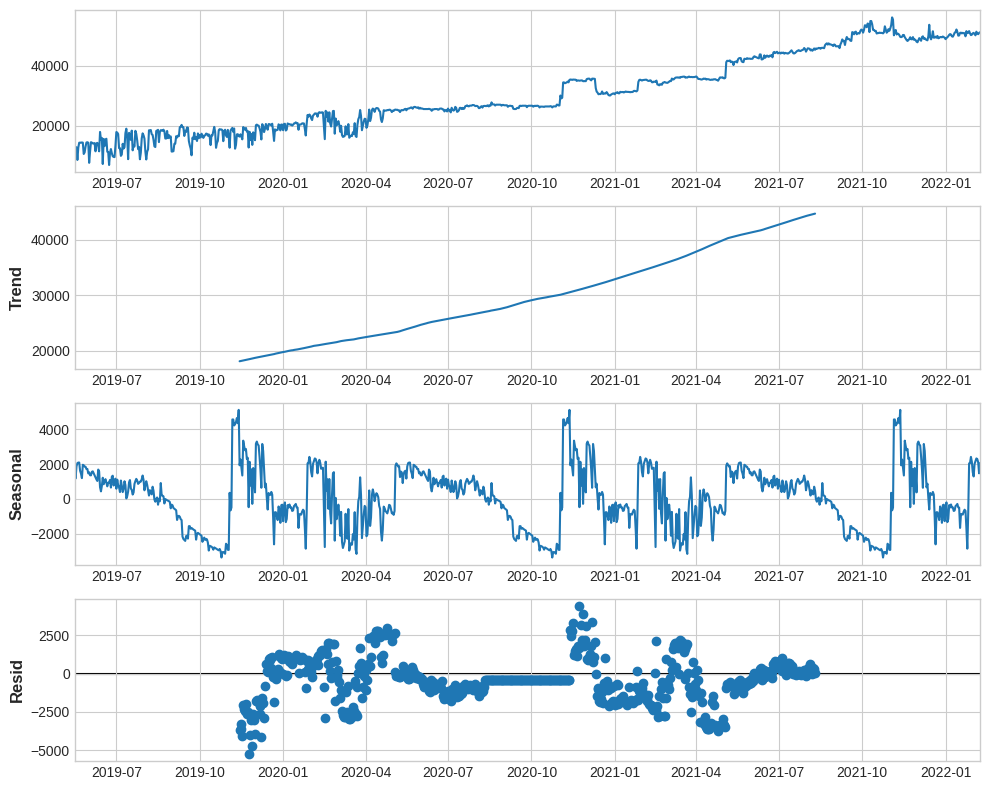

results for Gamma-c


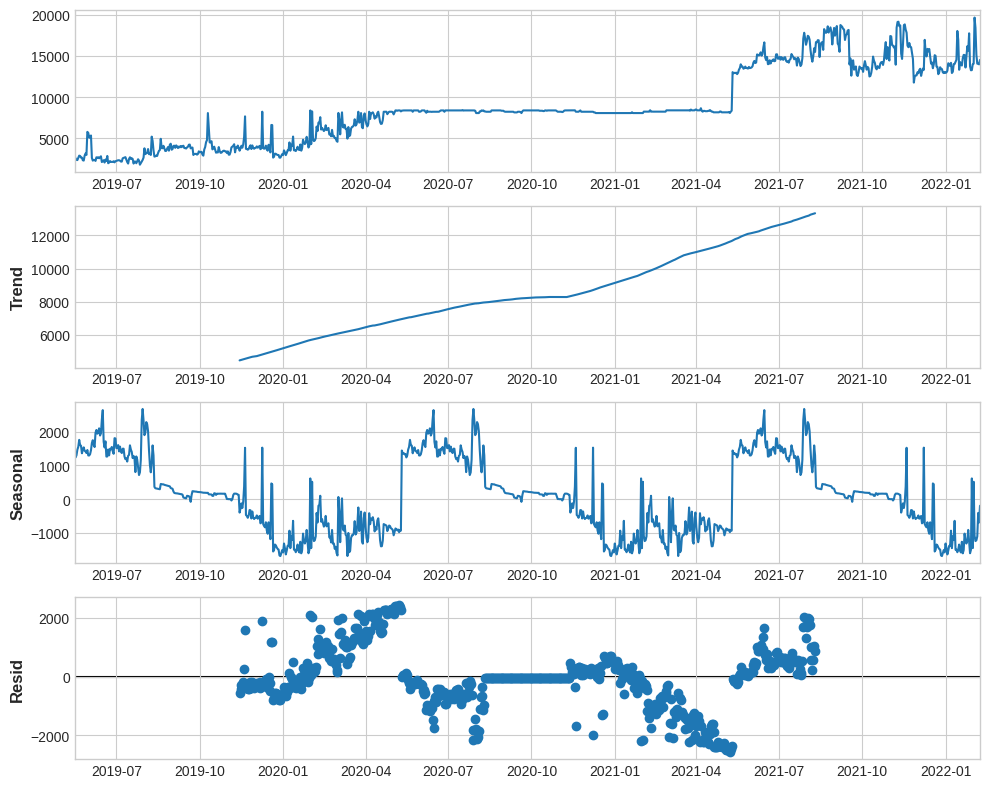

In [427]:
# visualize seasonal_decompose for every single region_zone
for i in data_time_series.Region_Zone.unique():
  data=data_time_series[data_time_series['Region_Zone']==i]
  result = seasonal_decompose(data[['Sold QTY']], model='additive',period = 365)
  print('results for '+ i)
  result.plot()
  fig = plt.gcf()
  fig.set_size_inches(10, 8)
  plt.show() # trend is based on 12 month moving avg. Seasonality is month to month ratios

In [428]:
# Display data_time_series
data_time_series

Region_Zone  Sold QTY  Year  Month  Weeknum  day weekday    Lag_1  \
usage_date                                                                     
2019-05-17     Alpha-a         0  2019      5       20   17       4      0.0   
2019-05-18     Alpha-a         0  2019      5       20   18       5      0.0   
2019-05-19     Alpha-a         0  2019      5       21   19       6      0.0   
2019-05-20     Alpha-a         0  2019      5       21   20       0      0.0   
2019-05-21     Alpha-a         0  2019      5       21   21       1      0.0   
...                ...       ...   ...    ...      ...  ...     ...      ...   
2022-02-04     Gamma-c     15157  2022      2        6    4       4  18416.0   
2022-02-05     Gamma-c     14065  2022      2        6    5       5  15157.0   
2022-02-06     Gamma-c     14048  2022      2        7    6       6  14065.0   
2022-02-07     Gamma-c     13984  2022      2        7    7       0  14048.0   
2022-02-08     Gamma-c     14528  2022      2        7    8       1  13984.0   

            const    trend  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  
usage_date                                                                  
2019-05-17    1.0      1.0     0.0     0.0     0.0     0.0     0.0     0.0  
2019-05-18    1.0      2.0     1.0     0.0     0.0     0.0     0.0     0.0  
2019-05-19    1.0      3.0     0.0     1.0     0.0     0.0     0.0     0.0  
2019-05-20    1.0      4.0     0.0     0.0     1.0     0.0     0.0     0.0  
2019-05-21    1.0      5.0     0.0     0.0     0.0     1.0     0.0     0.0  
...           ...      ...     ...     ...     ...     ...     ...     ...  
2022-02-04    1.0  12995.0     0.0     1.0     0.0     0.0     0.0     0.0  
2022-02-05    1.0  12996.0     0.0     0.0     1.0     0.0     0.0     0.0  
2022-02-06    1.0  12997.0     0.0     0.0     0.0     1.0     0.0     0.0  
2022-02-07    1.0  12998.0     0.0     0.0     0.0     0.0     1.0     0.0  
2022-02-08    1.0  12999.0     0.0     0.0     0.0     0.0     0.0     1.0  

[12999 rows x 16 columns]

In [429]:
# import plot_pacf and plot_acf

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

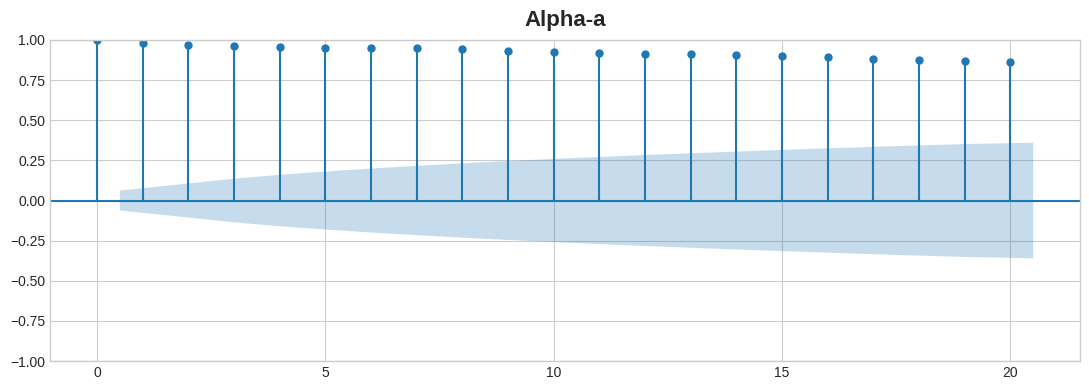

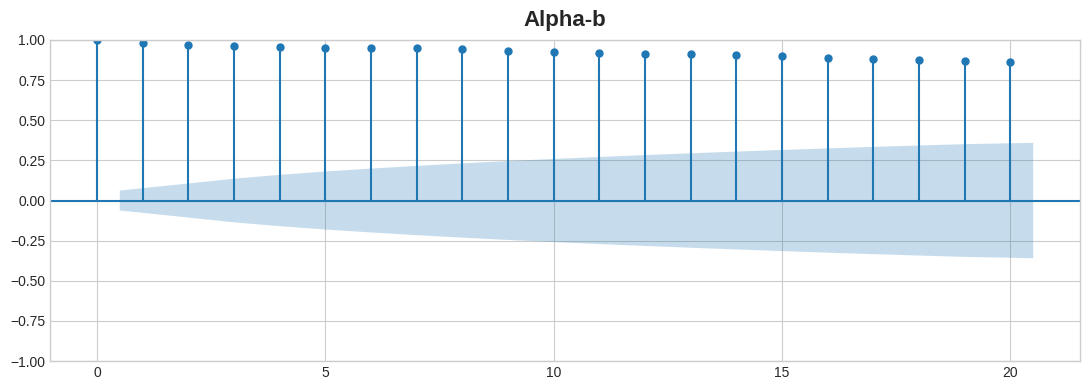

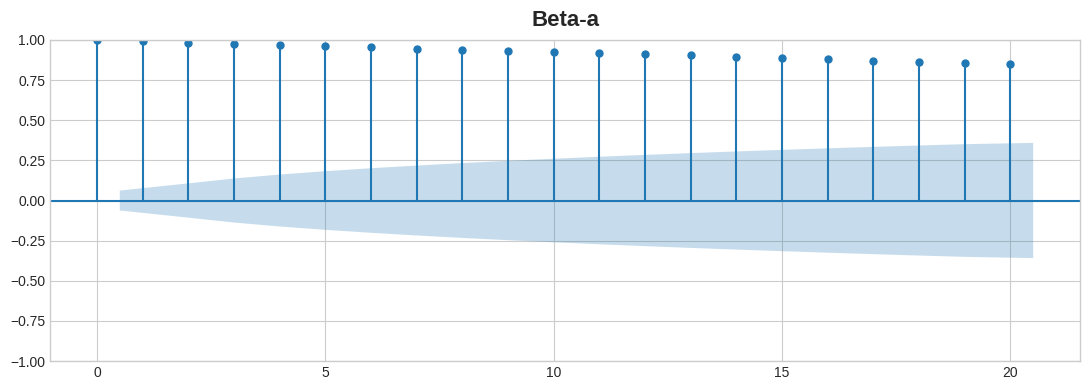

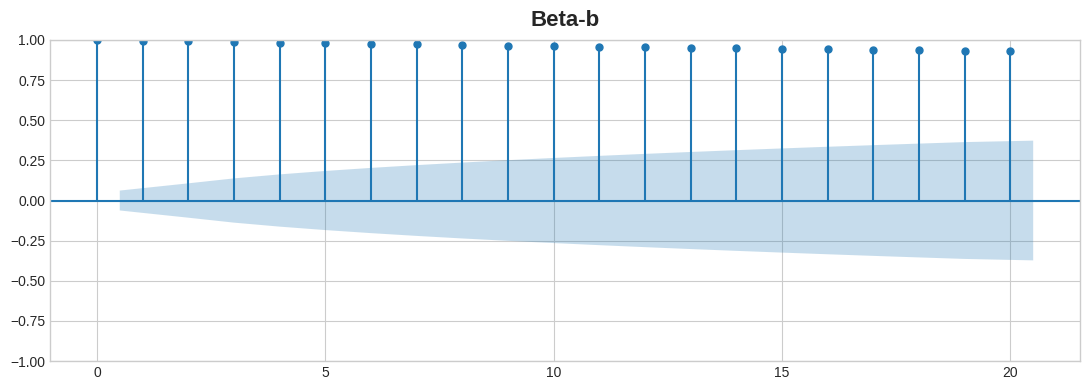

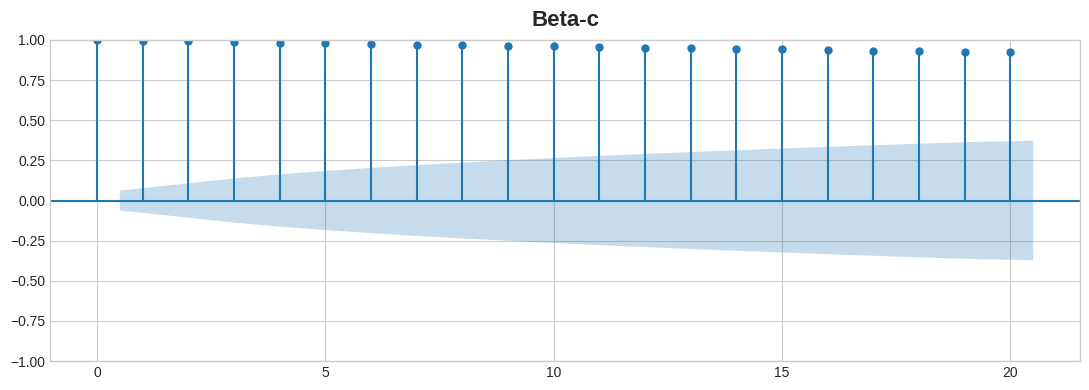

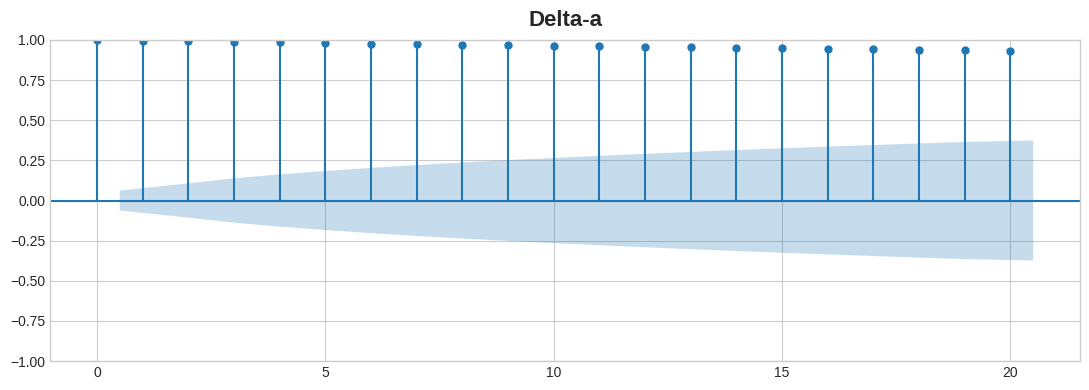

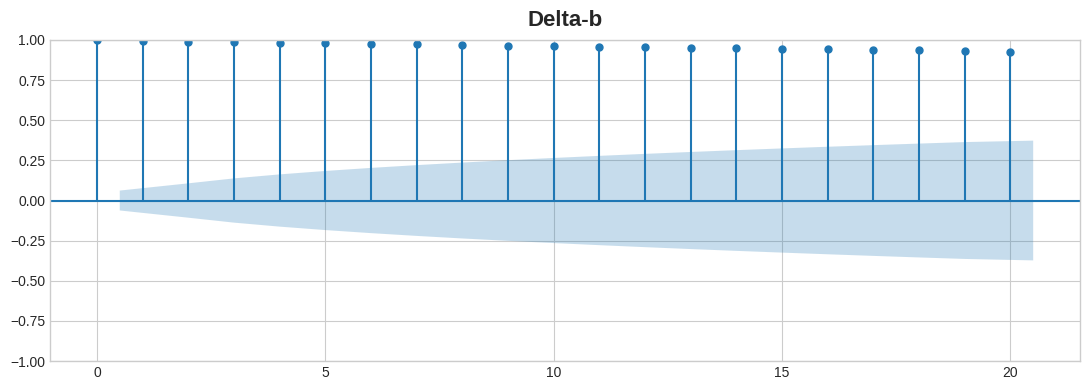

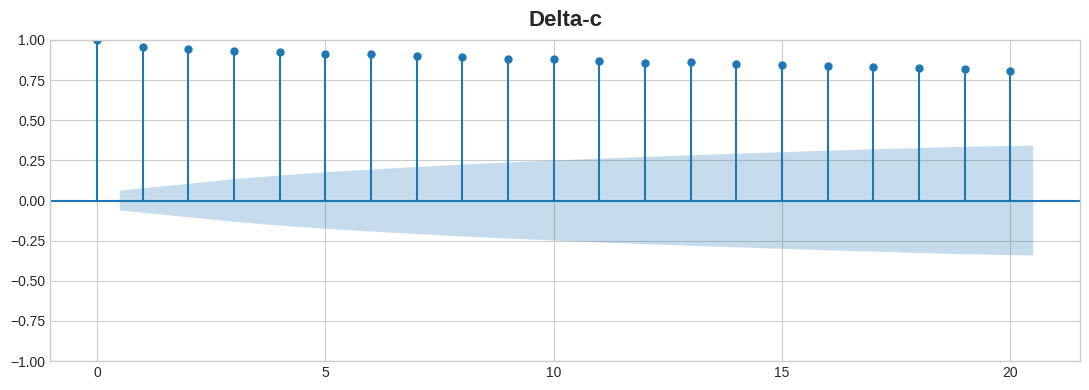

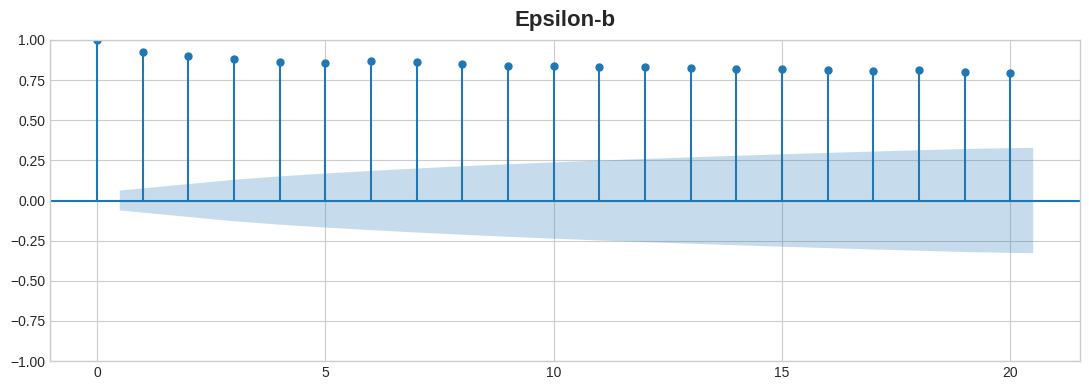

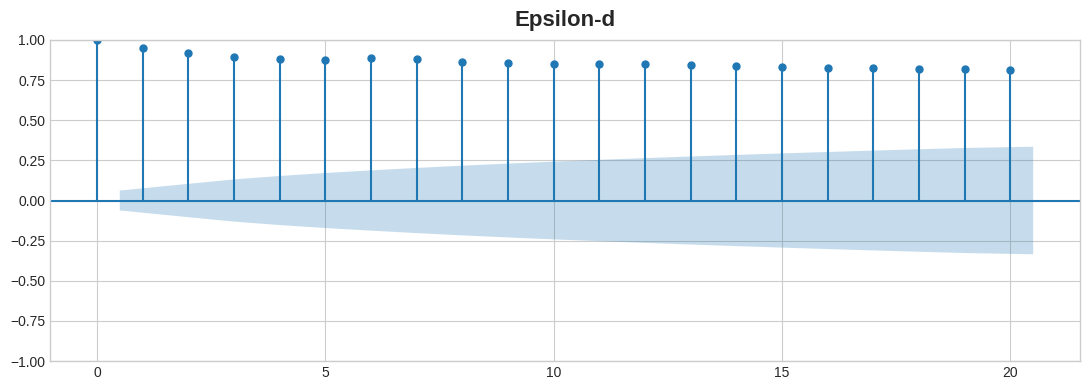

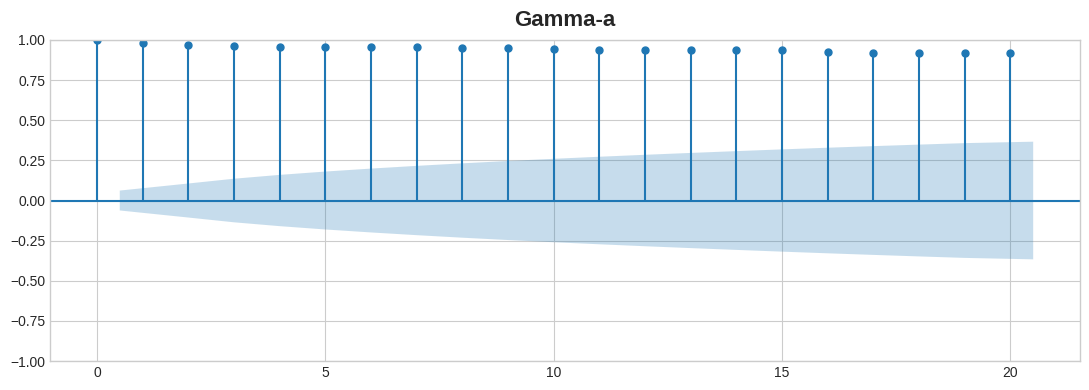

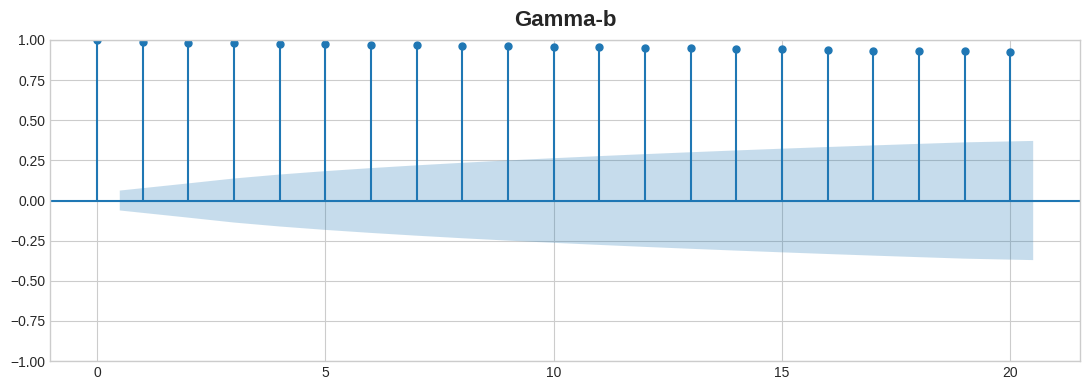

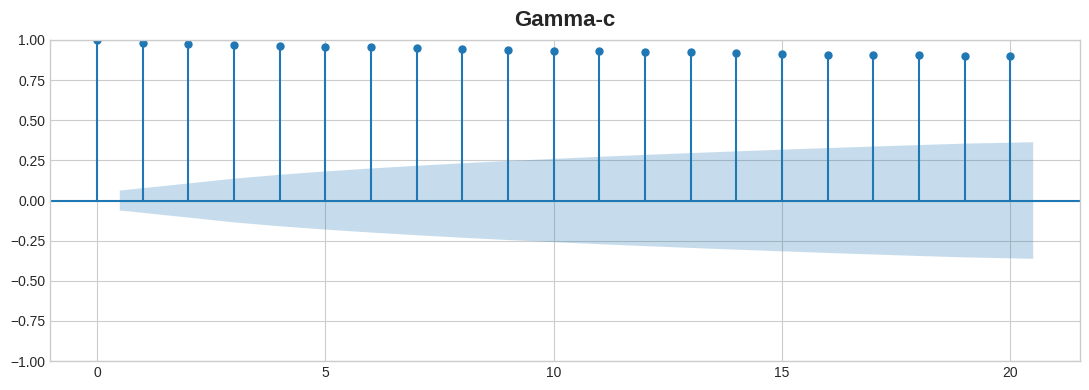

In [430]:
# plot_acf for every single region_zone
for i in data_time_series.Region_Zone.unique():
  data=data_time_series[data_time_series['Region_Zone']==i] 
  plot_acf(data[['Sold QTY']], lags=20,title=i)

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/

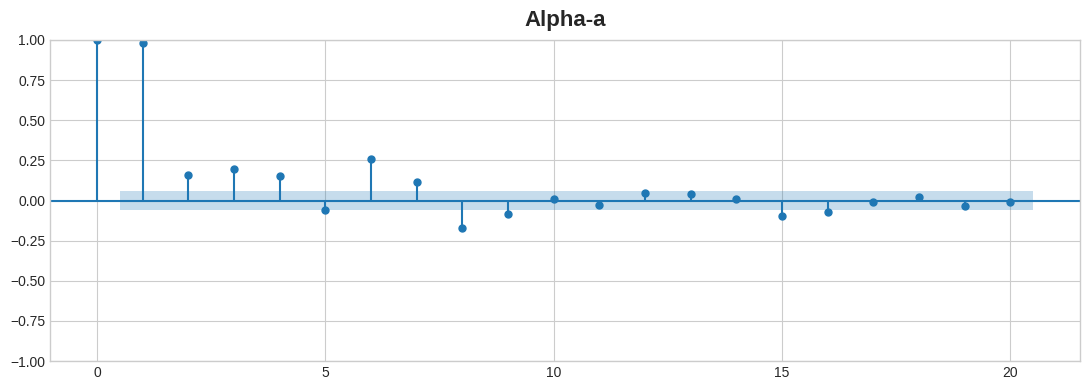

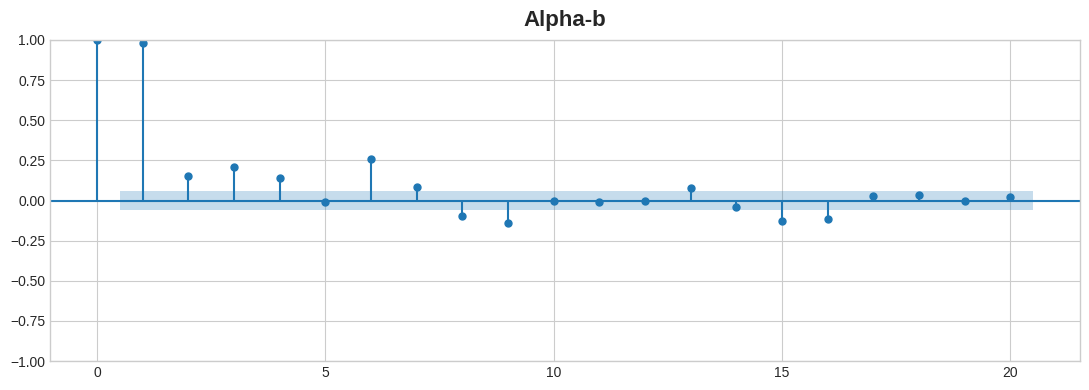

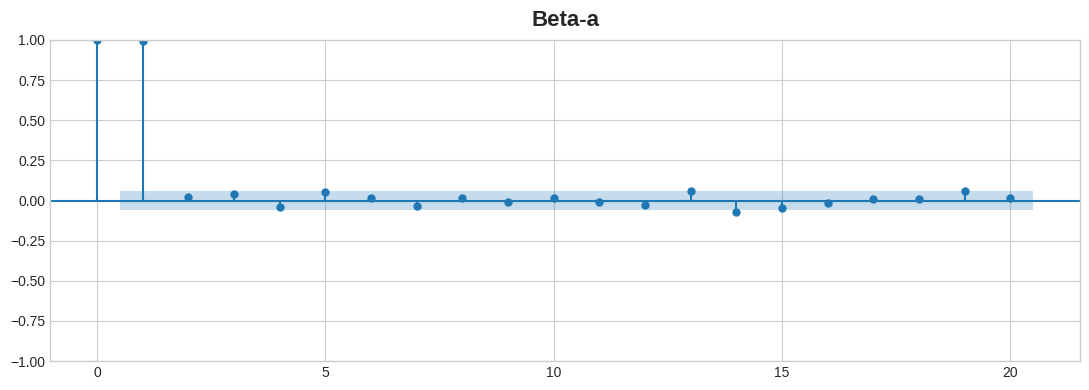

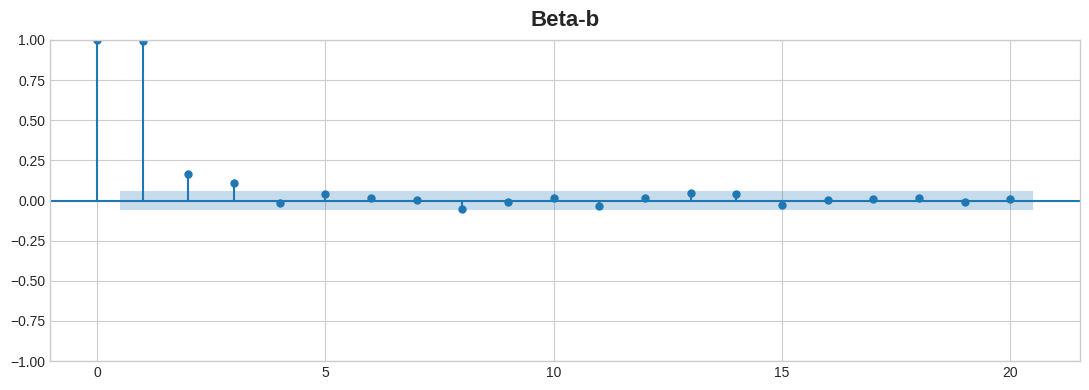

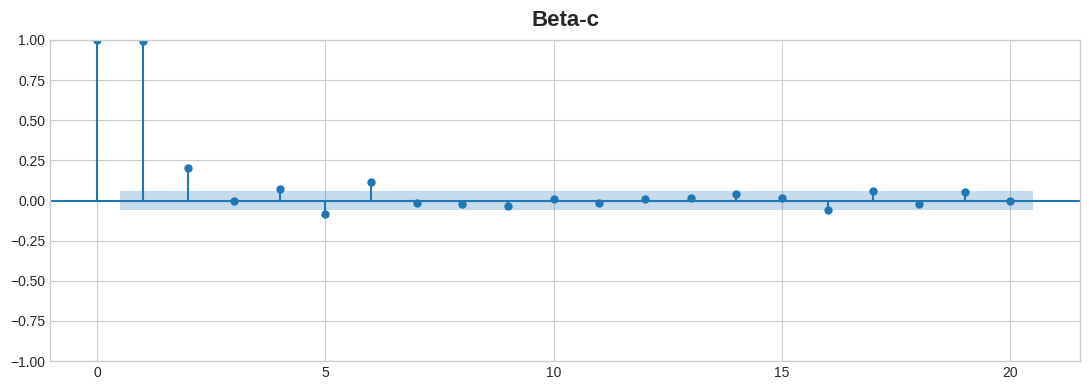

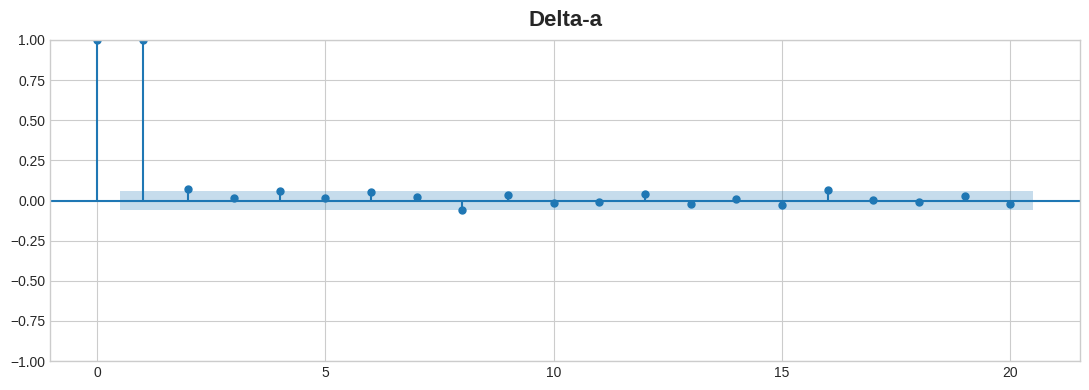

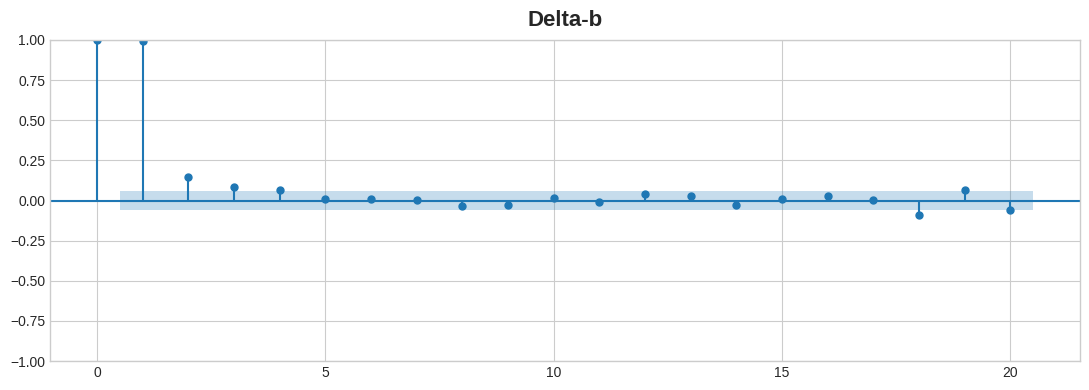

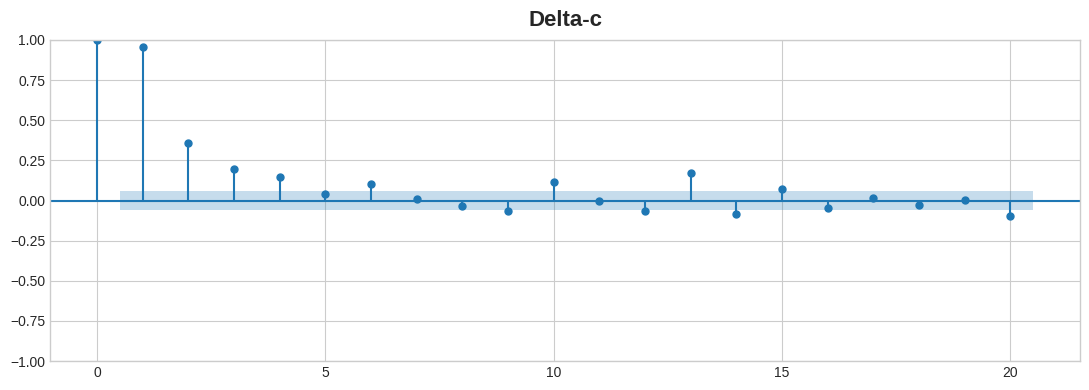

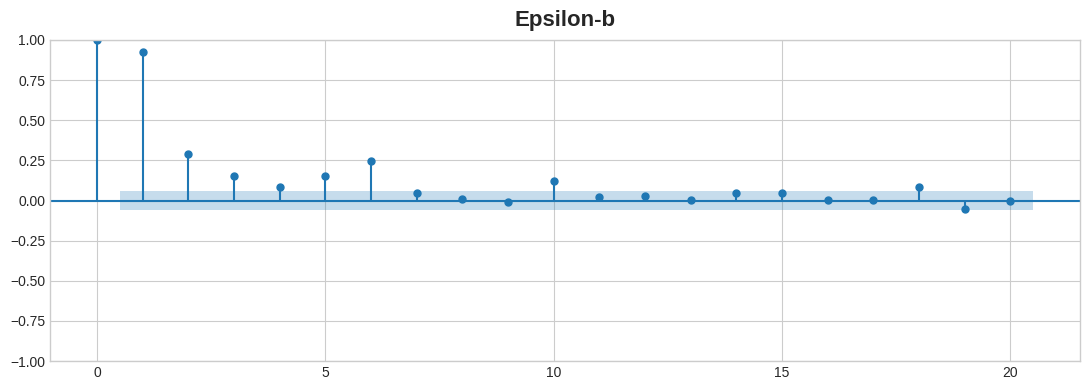

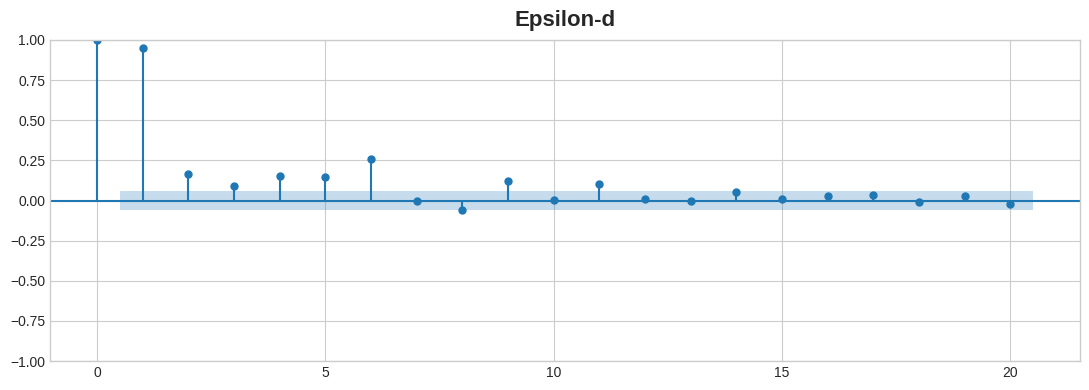

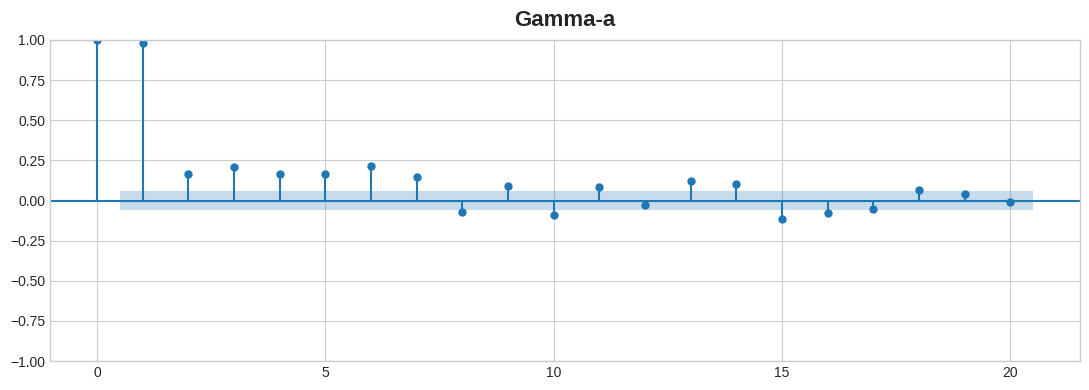

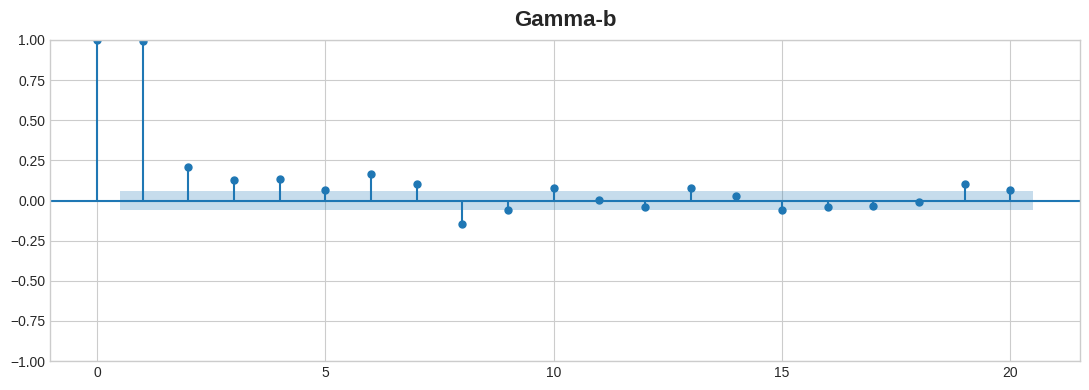

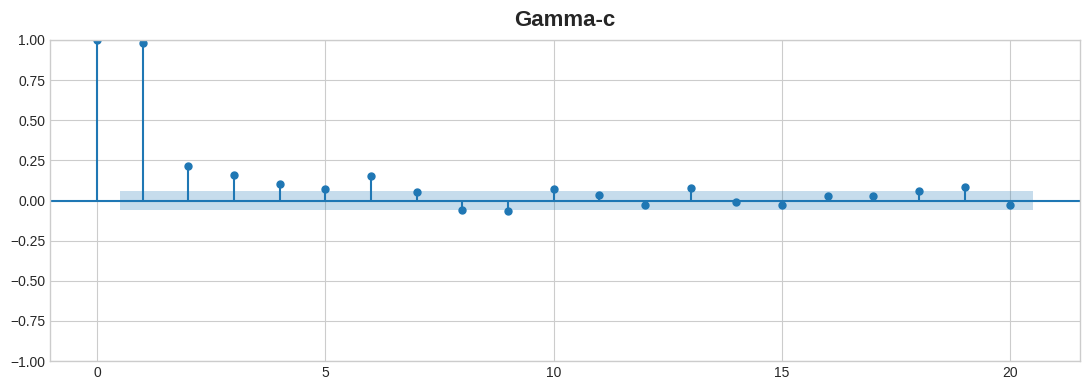

In [431]:
  # plot_pacf for every single region_zone
  for i in data_time_series.Region_Zone.unique():
    data=data_time_series[data_time_series['Region_Zone']==i] 
    plot_pacf(data[['Sold QTY']], lags=20,title=i);

In [432]:
#training and testing with selected model for a regional zone:
def train_and_test(df):
  df = df[df['Sold QTY'] > 0]
  X = df.drop(columns = ['Region_Zone','Sold QTY'])
  y = df['Sold QTY']

  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)
  my_pipeline.fit(X_train,y_train)
  preds = my_pipeline.predict(X_valid)
  mse = mean_squared_error(y_valid, preds)
  rmse = mean_squared_error(y_valid, preds, squared=False)
  mape = mean_absolute_percentage_error(y_valid, preds)
  smape = f_smape(y_valid, preds[0])
  table = pd.DataFrame({'MSE':[mse], 'RMSE':[rmse], 'MAPE':[mape],'SMAPE':[smape]})
  return table

In [433]:
training_results = pd.DataFrame()
for i in range(len(region_names)):
  df = region_data_frames[i]
  region_result = train_and_test(df)
  region_result["Region_Zone"] = region_names[i]
  training_results = pd.concat([training_results, region_result], axis=0)
training_results

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

MSE           RMSE       MAPE     SMAPE Region_Zone
0  2.354335e+10  153438.429923  21.172981  0.259811     Alpha-a
0  3.190666e+10  178624.357658  26.414103  0.258379     Alpha-b
0  1.224255e+04     110.646053   0.054999  0.020574      Beta-a
0  4.338396e+04     208.288172   0.018168  0.165007      Beta-b
0  3.046385e+05     551.940642   0.086119  0.119567      Beta-c
0  5.563290e+04     235.866266   0.022172  0.173023     Delta-a
0  9.194675e+04     303.227226   0.023268  0.081364     Delta-b
0  1.340782e+05     366.166863   0.043133  0.183041     Delta-c
0  4.102319e+05     640.493520   0.052070  0.191311   Epsilon-b
0  5.092153e+04     225.657987   0.032495  0.181192   Epsilon-d
0  1.720905e+06    1311.832876   0.017416  0.089523     Gamma-a
0  5.682423e+06    2383.783403   0.041160  0.142455     Gamma-b
0  3.611161e+06    1900.305524   0.085989  0.142350     Gamma-c

In [450]:
#training and testing with selected model for a regional zone without Lag_1:
def train_and_test2(df):
  df = df[df['Sold QTY'] > 0]
  X = df.drop(columns = ['Region_Zone','Sold QTY','Lag_1'])
  y = df['Sold QTY']

  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)
  my_pipeline.fit(X_train,y_train)
  preds = my_pipeline.predict(X_valid)
  mse = mean_squared_error(y_valid, preds)
  rmse = mean_squared_error(y_valid, preds, squared=False)
  mape = mean_absolute_percentage_error(y_valid, preds)
  smape = f_smape(y_valid, preds[0])
  table = pd.DataFrame({'MSE':[mse], 'RMSE':[rmse], 'MAPE':[mape],'SMAPE':[smape]})
  return table

In [451]:
training_results = pd.DataFrame()
for i in range(len(region_names)):
  df = region_data_frames[i]
  region_result = train_and_test2(df)
  region_result["Region_Zone"] = region_names[i]
  training_results = pd.concat([training_results, region_result], axis=0)
training_results

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

MSE           RMSE        MAPE     SMAPE Region_Zone
0  4.129413e+11  642605.071592   88.647498  0.326330     Alpha-a
0  8.512762e+11  922646.311473  136.355988  0.370094     Alpha-b
0  7.912345e+04     281.288917    0.140240  0.020821      Beta-a
0  4.477596e+05     669.148442    0.060486  0.168660      Beta-b
0  1.518525e+06    1232.284570    0.196307  0.103653      Beta-c
0  1.079488e+05     328.555556    0.031205  0.094176     Delta-a
0  1.874723e+06    1369.205377    0.115607  0.053274     Delta-b
0  5.775914e+05     759.994316    0.083984  0.232391     Delta-c
0  3.002446e+06    1732.756847    0.146349  0.172514   Epsilon-b
0  2.926336e+05     540.956228    0.083630  0.170878   Epsilon-d
0  1.057465e+07    3251.868275    0.047186  0.077590     Gamma-a
0  2.510751e+07    5010.739328    0.091123  0.182366     Gamma-b
0  8.489000e+06    2913.588892    0.132381  0.196960     Gamma-c

In [434]:
from sklearn.model_selection import cross_val_score

def cross_validate(df, name):
  results_table = []
  scores = -1 * cross_val_score(my_pipeline, df.drop(columns = ['Region_Zone','Sold QTY'],axis=1), df['Sold QTY'],
                                cv=5,verbose=10,
                                scoring='neg_mean_absolute_percentage_error')
  for i, score in enumerate(scores):
    results_table.append((f'{name} linear Regression, Pipeline, Onehot encoding. Cross Validation fold {i}', score))

  results_table.append((f'{name} linear Regression, Pipeline, Onehot encoding. Cross Validation mean', scores.mean()))

  print(name + " MAPE scores:\n", scores)
  print(name + " Mean MAPE score:\n", scores.mean())  

In [435]:
for i in range(len(region_names)):
  cross_validate(region_data_frames[i], region_names[i])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you lea

[CV] START .....................................................................
[CV] END .............. score: (test=-585333372768104576.000) total time=   0.0s
[CV] START .....................................................................
[CV] END .............. score: (test=-362784488971978944.000) total time=   0.0s
[CV] START .....................................................................
[CV] END .............. score: (test=-520319044088941632.000) total time=   0.0s
[CV] START .....................................................................
[CV] END .............. score: (test=-722417606644073600.000) total time=   0.0s
[CV] START .....................................................................
[CV] END ................. score: (test=-262922720443443.906) total time=   0.0s
Alpha-a MAPE scores:
 [5.85333373e+17 3.62784489e+17 5.20319044e+17 7.22417607e+17
 2.62922720e+14]
Alpha-a Mean MAPE score:
 4.382234870387084e+17
[CV] START ...............................

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leav

[CV] END .............. score: (test=-176056028414032192.000) total time=   0.0s
[CV] START .....................................................................
[CV] END .............. score: (test=-138221905625985760.000) total time=   0.0s
[CV] START .....................................................................
[CV] END .............. score: (test=-509927802070691328.000) total time=   0.0s
[CV] START .....................................................................
[CV] END .............. score: (test=-854398180225478784.000) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.705) total time=   0.0s
Beta-a MAPE scores:
 [1.76056028e+17 1.38221906e+17 5.09927802e+17 8.54398180e+17
 7.05000000e-01]
Beta-a Mean MAPE score:
 3.3572078326723757e+17
[CV] START .....................................................................
[CV] END ............................... sc

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encode

[CV] START .....................................................................
[CV] END ............................... score: (test=-0.096) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.060) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.044) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.074) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.086) total time=   0.0s
Beta-c MAPE scores:
 [0.0960243  0.06029935 0.04415899 0.07361687 0.08611905]
Beta-c Mean MAPE score:
 0.07204371165638342
[CV] START ........................................................

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encode

[CV] START .....................................................................
[CV] END ............................... score: (test=-1.267) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.045) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.043) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.024) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.023) total time=   0.0s
Delta-b MAPE scores:
 [1.26723175 0.04534271 0.04266354 0.02393504 0.02326777]
Delta-b Mean MAPE score:
 0.2804881636505431
[CV] START .......................................................

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encode

[CV] END ............................... score: (test=-0.043) total time=   0.0s
Delta-c MAPE scores:
 [0.14035299 0.11240347 0.19942791 0.10727801 0.04313272]
Delta-c Mean MAPE score:
 0.12051902017972904
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.231) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.107) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.201) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.047) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.052) tot

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encode

[CV] END ............................... score: (test=-0.120) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.051) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.032) total time=   0.0s
Epsilon-d MAPE scores:
 [0.21541695 0.1710788  0.12015207 0.05142563 0.03249516]
Epsilon-d Mean MAPE score:
 0.11811372297082548
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.178) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.112) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.031)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leav

[CV] END ............................... score: (test=-0.067) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.027) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.041) total time=   0.0s
Gamma-b MAPE scores:
 [0.14534473 0.06073656 0.06674384 0.02700256 0.0411604 ]
Gamma-b Mean MAPE score:
 0.06819761478026432
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.168) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.168) total time=   0.0s
[CV] START .....................................................................
[CV] END ............................... score: (test=-0.069) tot

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leav

In [436]:
#The BoostedHybrid class defines a hybrid ensemble model that combines the predictions of two different models
#model_1 and model_2. The model_2 is trained on the residuals of the forecast of model_1. 
#This approach aims to capture the variance in the data that cannot be explained by model_1. 
#The fit method trains both models on the input data, while the predict method generates predictions 
#using the trained models. Overall, this implementation provides a flexible and effective way 
#to combine the strengths of multiple models to improve forecasting accuracy.
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1  
        self.model_2 = model_2 # Model 2 trains on the residuals of the forecast of model_1
        self.y_columns = None  # store column names from fit method


    def fit(self, X_1, X_2, y):
        # Train model_1
        self.model_1.fit(X_1, y)

        # Make predictions
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1), 
            index=X_1.index, columns=y.columns,
        )

        # Compute residuals
        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze() # wide to long

        # Train model_2 on residuals
        self.model_2.fit(X_2, y_resid)

        # Save column names for predict method
        self.y_columns = y.columns

        self.y_fit = y_fit
        self.y_resid = y_resid

    def predict(self, X_1, X_2):
        # Predict with model_1
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1), 
            index=X_1.index, columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()  # wide to long

        # Add model_2 predictions to model_1 predictions
        y_pred += self.model_2.predict(X_2)
        
        return pd.DataFrame(data=y_pred)

In [437]:
# This code sets several parameters for matplotlib plots, including the style, figure size, font sizes, and plot style parameters.
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

<ipython-input-437-82c8153273f6>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [468]:
# Define the function for Training Hybrid Model with all regional zones. 

from sklearn.ensemble import RandomForestRegressor

boosted_hybrid_model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=RandomForestRegressor(),
)

def fit_boosted_hybrid(df, name):
  df = df[df["Sold QTY"] > 0]
  X = df.drop(columns = ['Region_Zone','Sold QTY'])
  y = df[['Sold QTY']]
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)
  X_1_train = X_train.drop(columns = ['s(2,7)','s(3,7)','s(4,7)','s(5,7)','s(6,7)','s(7,7)','trend','const'])
  X_2_train = X_train.drop(columns = ['Year','Month','Weeknum','day','weekday'])
  X_1_valid = X_valid.drop(columns = ['s(2,7)','s(3,7)','s(4,7)','s(5,7)','s(6,7)','s(7,7)','trend','const'])
  X_2_valid = X_valid.drop(columns = ['Year','Month','Weeknum','day','weekday'])
  boosted_hybrid_model.fit(X_1_train, X_2_train, y_train)
  preds = boosted_hybrid_model.predict(X_1_valid, X_2_valid)
  preds = preds.clip(0.0) #.clip(0.0) removes negative values
  mse = mean_squared_error(y_valid, preds)
  rmse = mean_squared_error(y_valid, preds, squared=False)
  mape = mean_absolute_percentage_error(y_valid, preds)
  smape = f_smape(y_valid['Sold QTY'], preds[0])
  table = pd.DataFrame({'MSE':[mse], 'RMSE':[rmse], 'MAPE':[mape],'SMAPE':[smape]})

  #Display graph:
  preds['usage_date']=y_valid.index
  preds=preds.set_index('usage_date')
  preds = preds.rename(columns = {0:'Predics'})
  y_pred = preds.clip(0.0) #removes negative values
  ax = y.plot(**plot_params, alpha=0.5, title=f"Hybrid_Mode_{name}", ylabel="IAAS_Demand")
  ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
  ax.legend()
  return table

MSE         RMSE      MAPE     SMAPE Region_Zone
0  1.664596e+07  4079.946599  0.516034  0.718499     Alpha-a
0  1.001296e+07  3164.326619  0.416376  0.540802     Alpha-b
0  2.003921e+03    44.765174  0.024281  0.024042      Beta-a
0  1.696826e+05   411.925455  0.039757  0.040630      Beta-b
0  4.987379e+05   706.213770  0.112298  0.105138      Beta-c
0  7.272213e+04   269.670402  0.025636  0.026014     Delta-a
0  6.276584e+04   250.531117  0.017554  0.017755     Delta-b
0  3.826649e+05   618.599123  0.064129  0.067810     Delta-c
0  1.315709e+05   362.727031  0.028096  0.028358   Epsilon-b
0  6.414322e+05   800.894615  0.100860  0.107714   Epsilon-d
0  1.235420e+06  1111.494299  0.014378  0.014281     Gamma-a
0  4.751890e+06  2179.883063  0.023024  0.023824     Gamma-b
0  2.430856e+06  1559.120162  0.092409  0.089451     Gamma-c

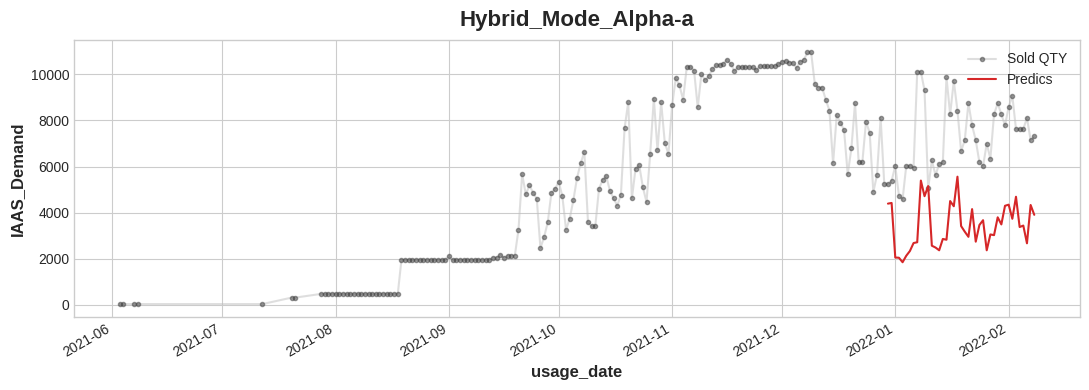

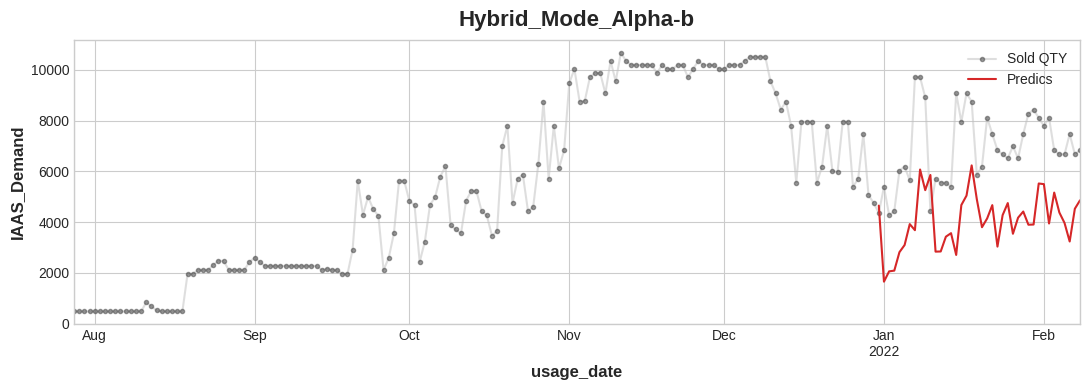

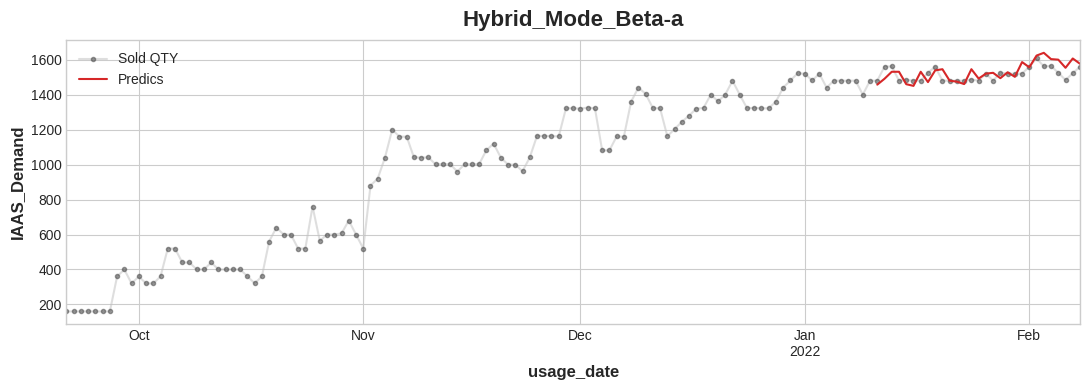

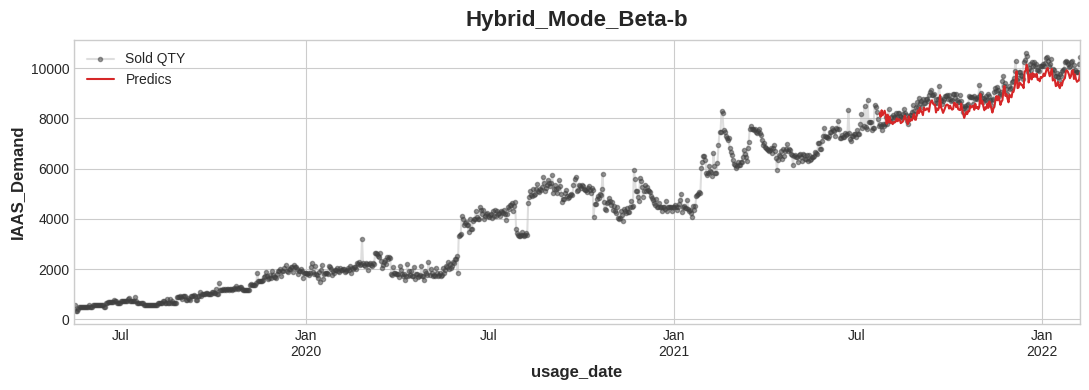

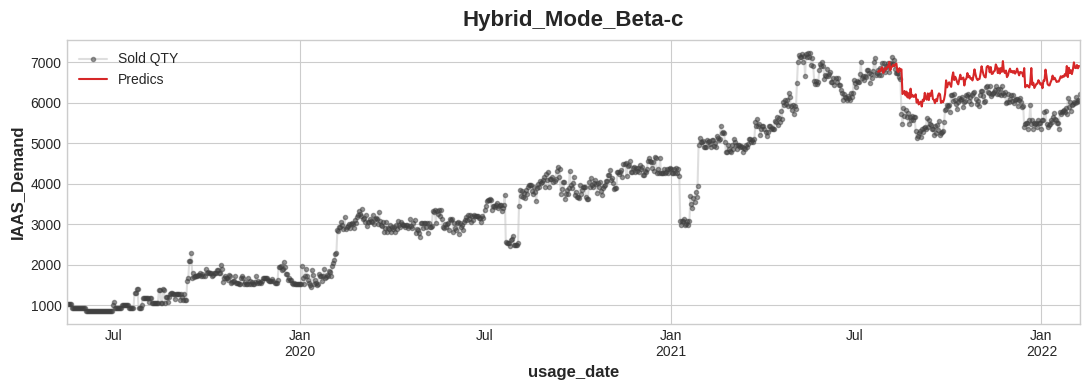

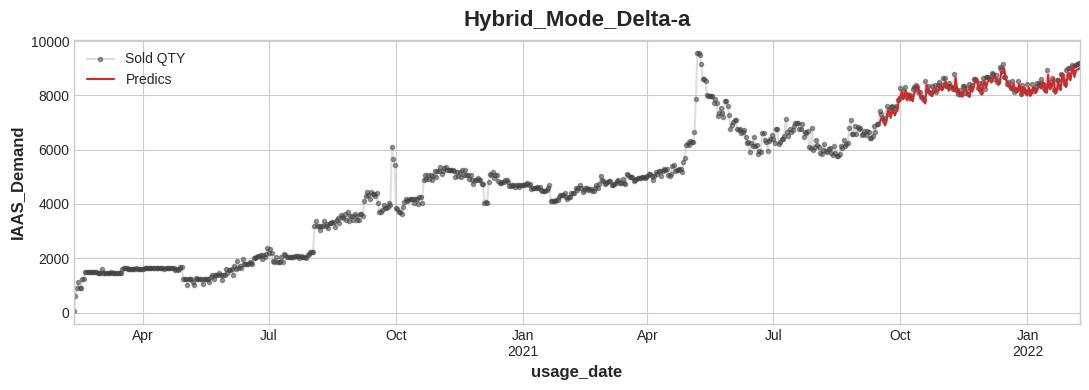

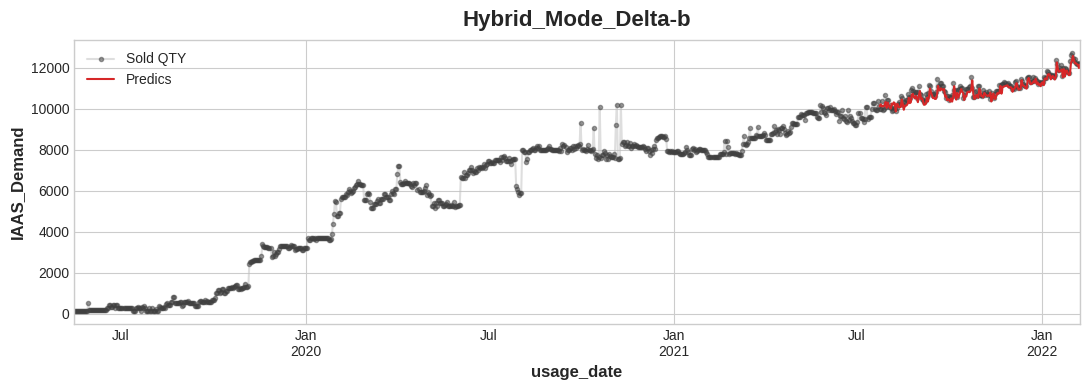

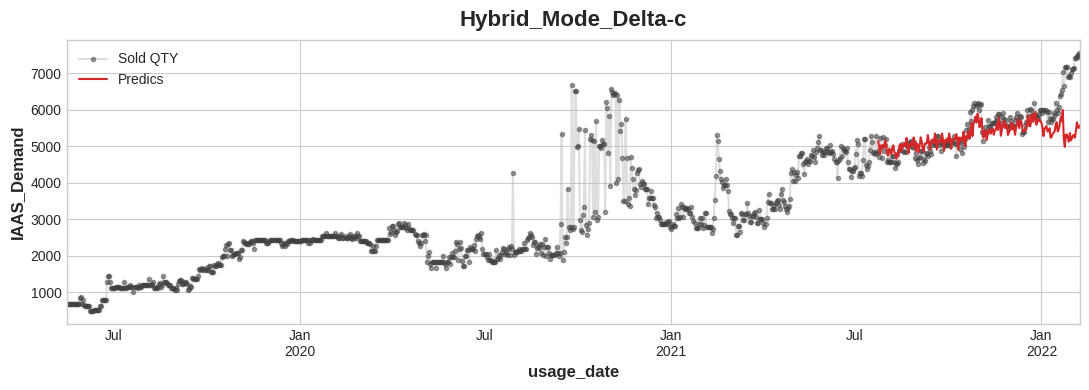

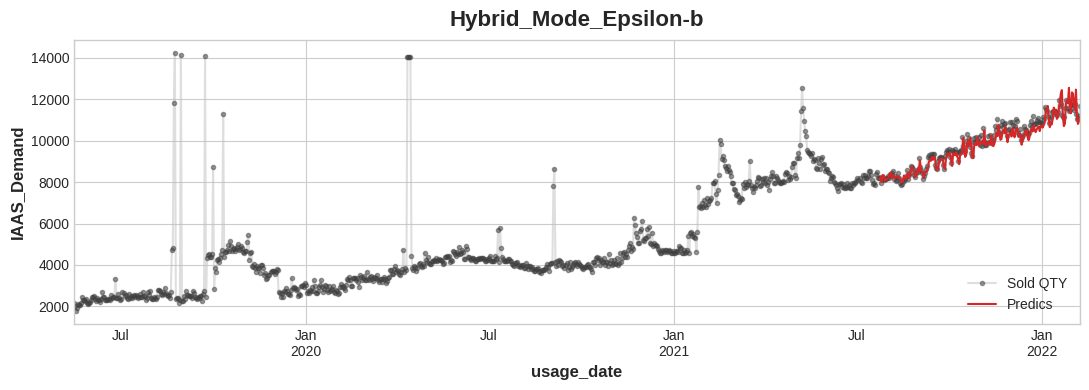

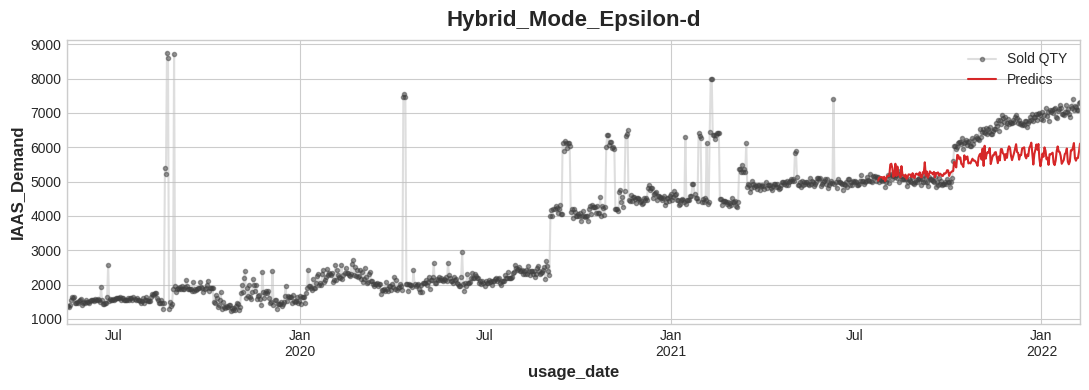

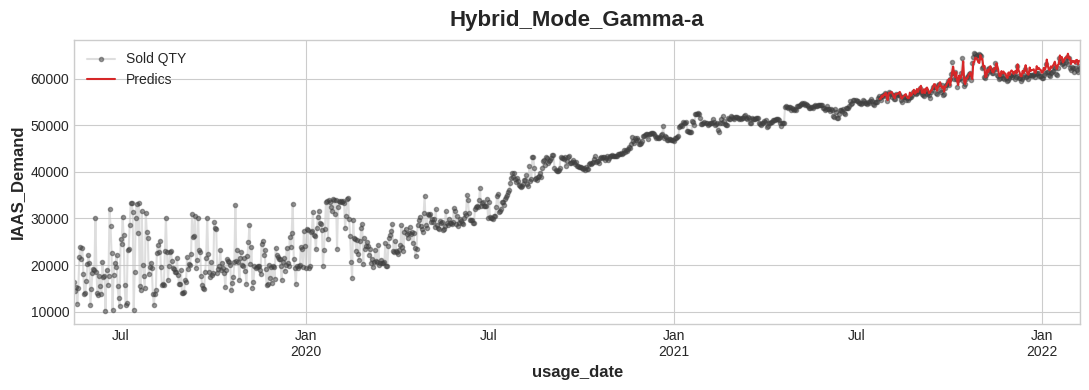

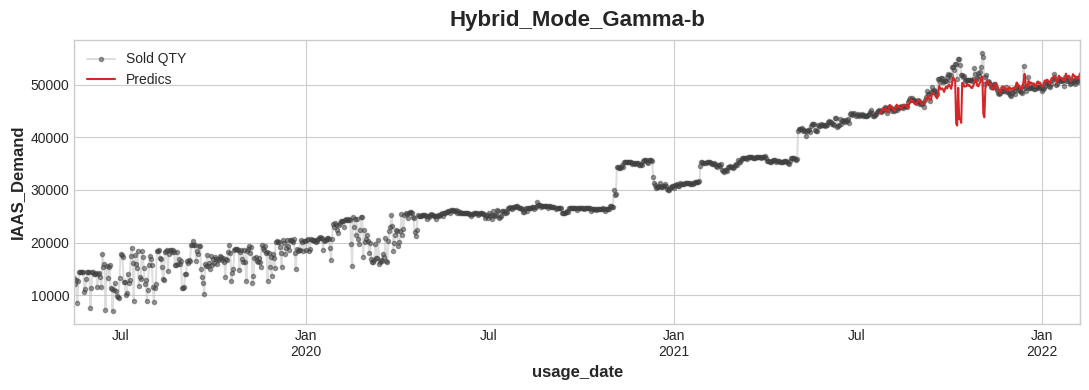

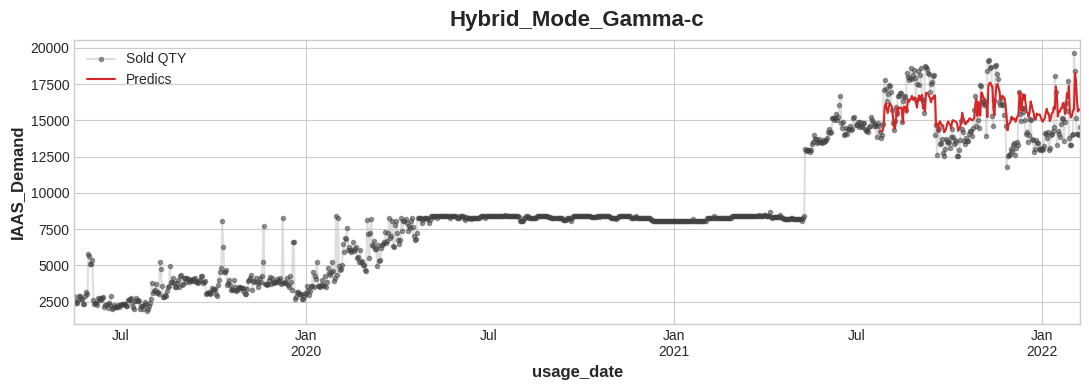

In [469]:
#Hybrid Model training and testing for all regions

boost_results = pd.DataFrame()
for i in range(len(region_names)):
  df = region_data_frames[i]
  region_result = fit_boosted_hybrid(df, region_names[i])
  region_result["Region_Zone"] = region_names[i]
  boost_results = pd.concat([boost_results, region_result], axis=0)
boost_results


In [440]:
# Reuse the pipeline except don't pass in the Lag_1 column:

no_lag_training_results = pd.DataFrame()
for i in range(len(region_names)):
  df = region_data_frames[i]
  df = df.drop(["Lag_1"], axis=1)
  region_result = train_and_test(df)
  region_result["Region_Zone"] = region_names[i]
  no_lag_training_results = pd.concat([no_lag_training_results, region_result], axis=0)
no_lag_training_results

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

MSE           RMSE        MAPE     SMAPE Region_Zone
0  4.129413e+11  642605.071592   88.647498  0.326330     Alpha-a
0  8.512762e+11  922646.311473  136.355988  0.370094     Alpha-b
0  7.912345e+04     281.288917    0.140240  0.020821      Beta-a
0  4.477596e+05     669.148442    0.060486  0.168660      Beta-b
0  1.518525e+06    1232.284570    0.196307  0.103653      Beta-c
0  1.079488e+05     328.555556    0.031205  0.094176     Delta-a
0  1.874723e+06    1369.205377    0.115607  0.053274     Delta-b
0  5.775914e+05     759.994316    0.083984  0.232391     Delta-c
0  3.002446e+06    1732.756847    0.146349  0.172514   Epsilon-b
0  2.926336e+05     540.956228    0.083630  0.170878   Epsilon-d
0  1.057465e+07    3251.868275    0.047186  0.077590     Gamma-a
0  2.510751e+07    5010.739328    0.091123  0.182366     Gamma-b
0  8.489000e+06    2913.588892    0.132381  0.196960     Gamma-c

MSE         RMSE      MAPE     SMAPE Region_Zone
0  5.375474e+07  7331.762361  0.959530  1.910096     Alpha-a
0  4.952377e+07  7037.312345  0.983423  1.957209     Alpha-b
0  2.764632e+04   166.271821  0.085410  0.080101      Beta-a
0  1.290251e+05   359.200665  0.030913  0.031130      Beta-b
0  3.125430e+06  1767.888561  0.282975  0.242340      Beta-c
0  6.685922e+05   817.674897  0.089747  0.094676     Delta-a
0  4.629328e+05   680.391635  0.053168  0.051408     Delta-b
0  4.115328e+05   641.508223  0.082436  0.083851     Delta-c
0  1.763824e+06  1328.090280  0.109079  0.117372   Epsilon-b
0  4.620233e+05   679.722972  0.095553  0.099234   Epsilon-d
0  4.612638e+06  2147.705367  0.028139  0.027833     Gamma-a
0  5.256011e+06  2292.599123  0.032613  0.033423     Gamma-b
0  5.222359e+06  2285.248044  0.137580  0.132252     Gamma-c

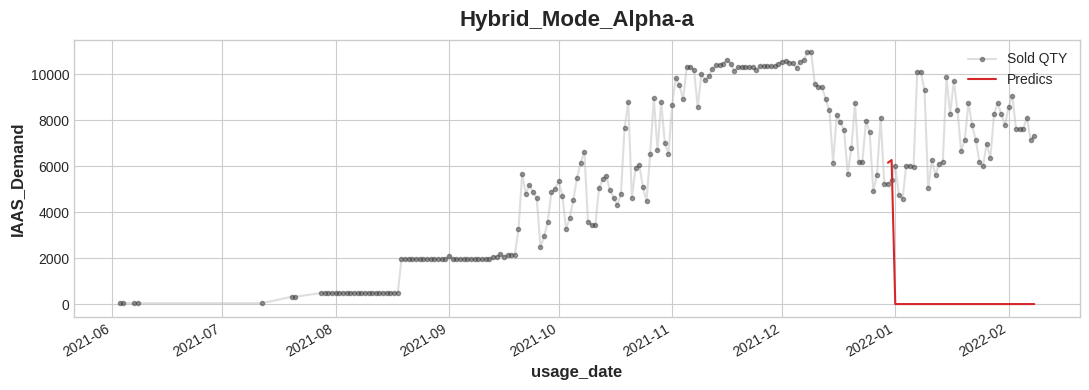

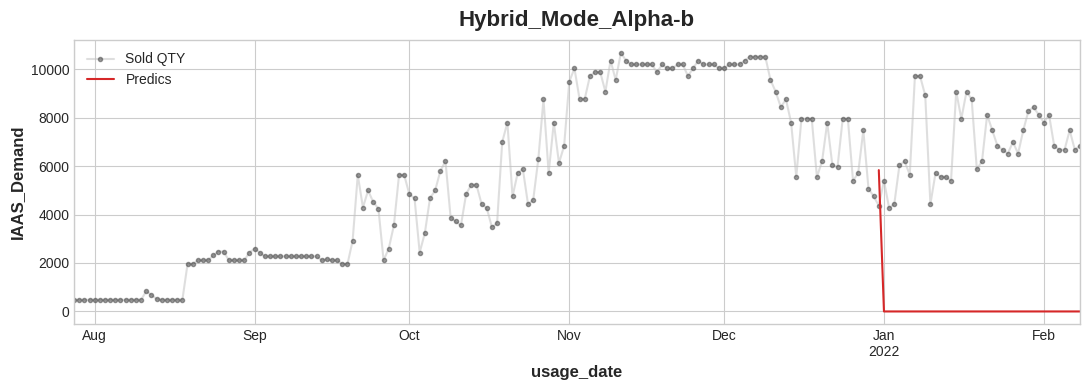

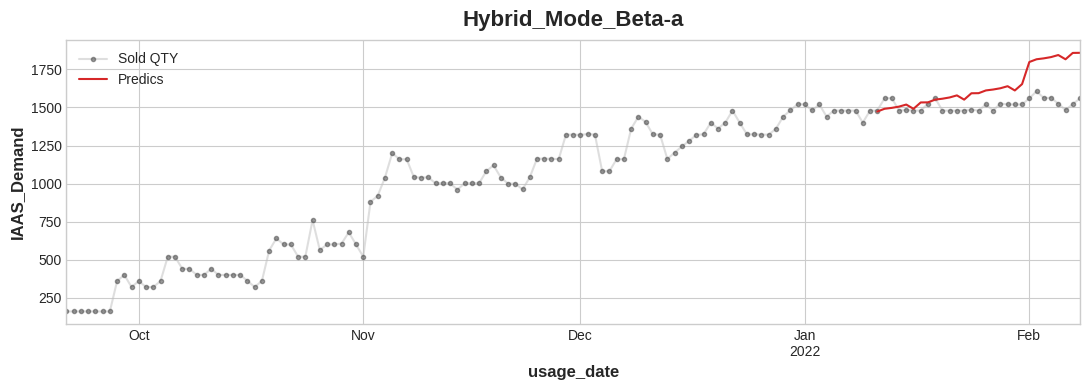

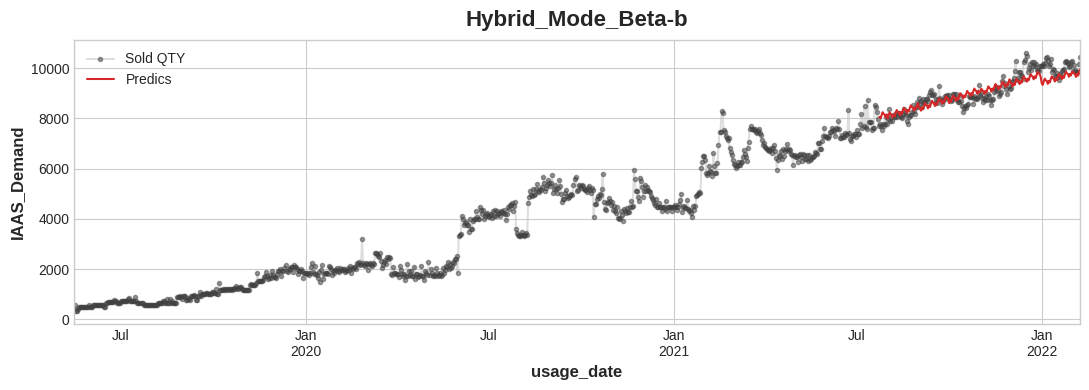

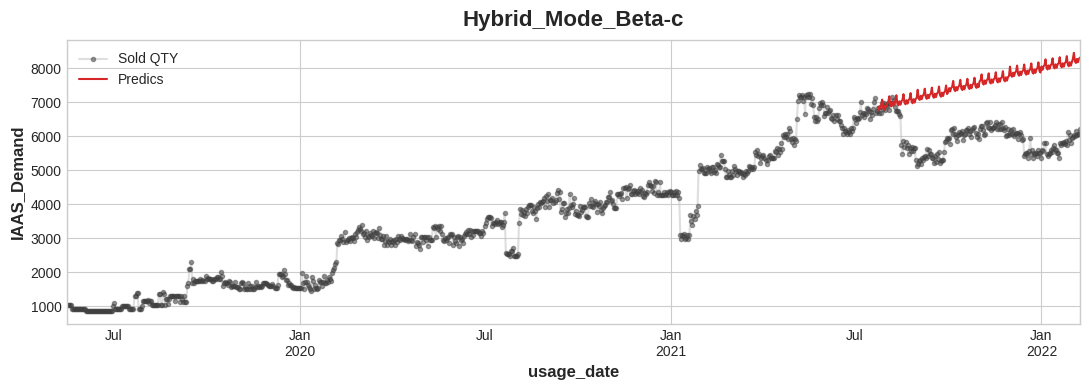

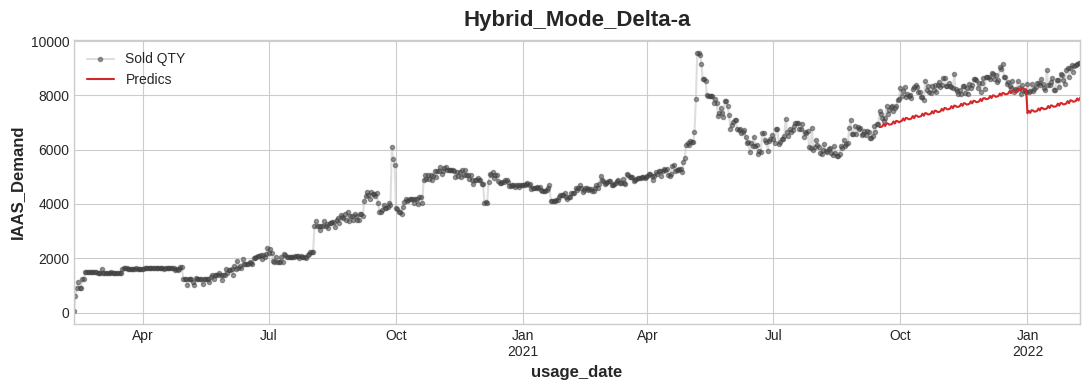

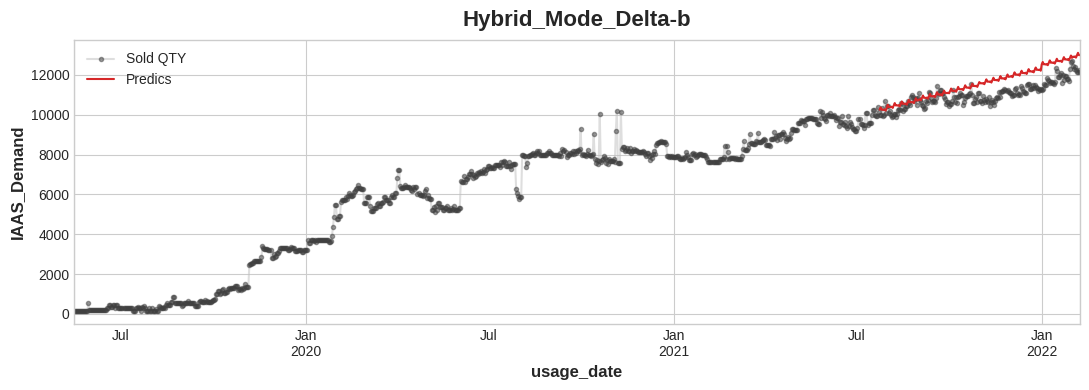

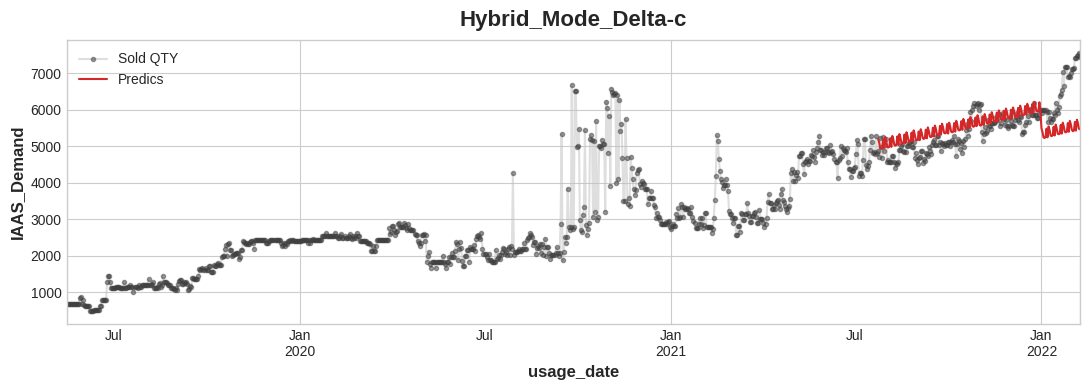

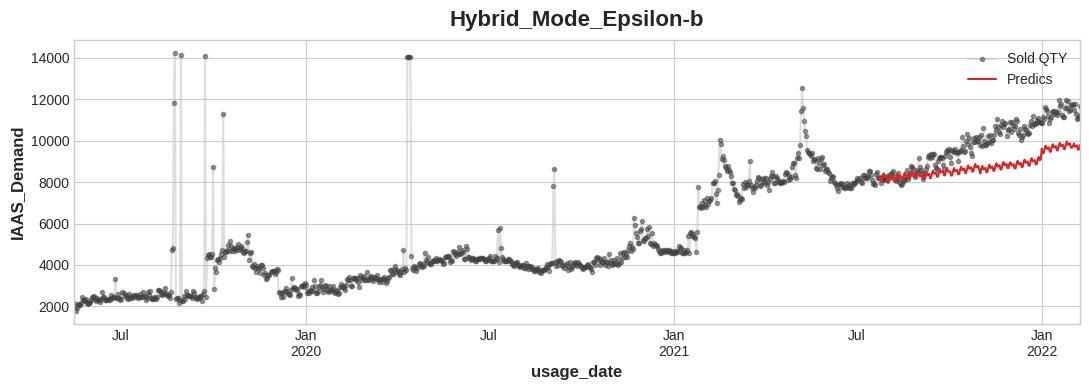

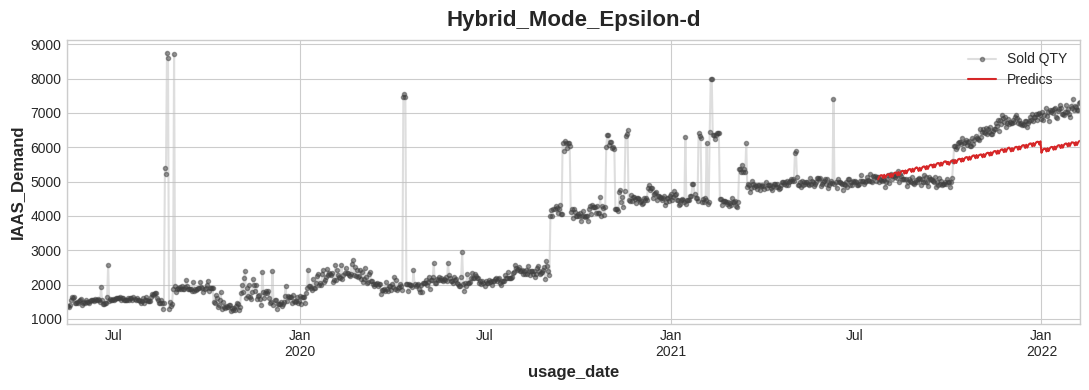

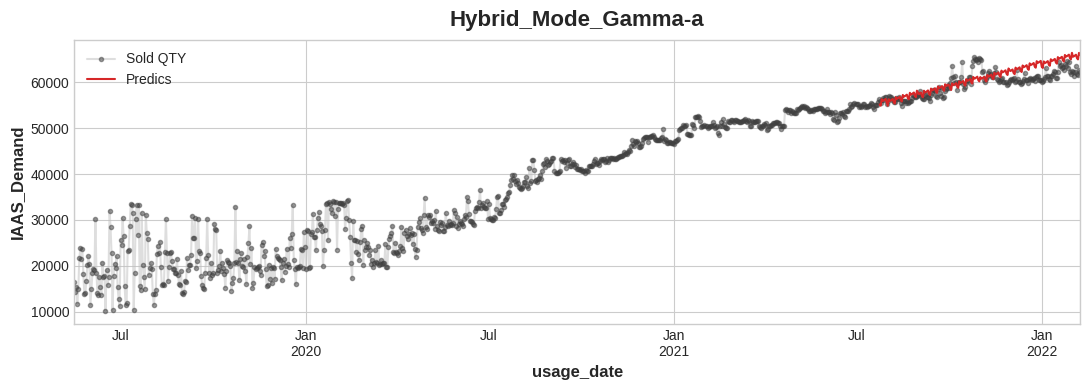

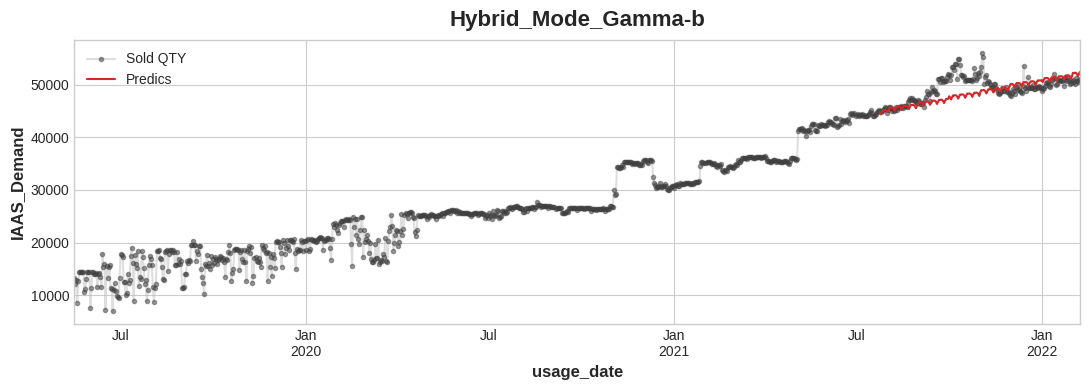

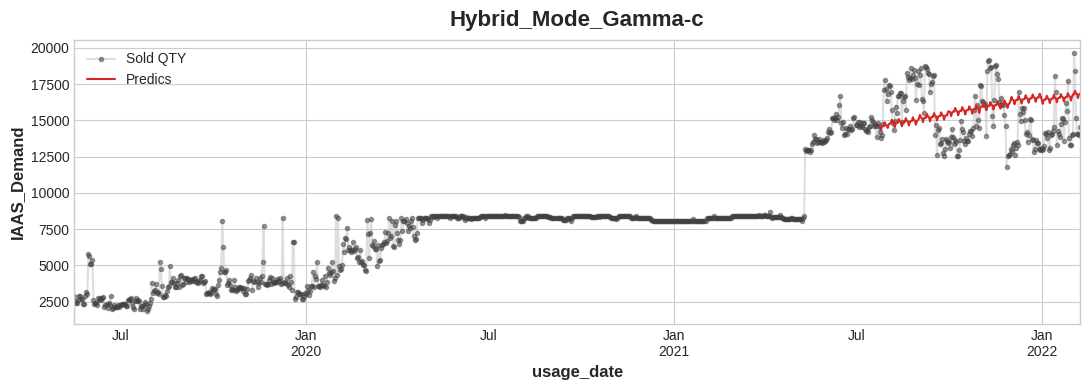

In [441]:
####Removing Lag_1 + Hybrid Model

no_lag_boost_results = pd.DataFrame()
for i in range(len(region_names)):
  df = region_data_frames[i]
  df = df.drop(["Lag_1"], axis=1)
  region_result = fit_boosted_hybrid(df, region_names[i])
  region_result["Region_Zone"] = region_names[i]
  no_lag_boost_results = pd.concat([no_lag_boost_results, region_result], axis=0)
no_lag_boost_results

In [442]:
# Forecsting for next 18 month, creating dataset. 
start_date = "2022-02-09"
end_date = "2023-08-09"

date_range = pd.date_range(start=start_date, end=end_date, freq="D")
df = pd.DataFrame(index=date_range)

df["Year"] = df.index.year
df["Month"] = df.index.month
df["Weeknum"] = df.index.week
df["day"] = df.index.day
df["weekday"] = df.index.weekday

df

<ipython-input-442-2c7c34b49ccd>:10: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df["Weeknum"] = df.index.week


Year  Month  Weeknum  day  weekday
2022-02-09  2022      2        6    9        2
2022-02-10  2022      2        6   10        3
2022-02-11  2022      2        6   11        4
2022-02-12  2022      2        6   12        5
2022-02-13  2022      2        6   13        6
...          ...    ...      ...  ...      ...
2023-08-05  2023      8       31    5        5
2023-08-06  2023      8       31    6        6
2023-08-07  2023      8       32    7        0
2023-08-08  2023      8       32    8        1
2023-08-09  2023      8       32    9        2

[547 rows x 5 columns]

In [443]:
# Forecsting for next 18 month, creating dataset. 
y=df['Year'].copy()
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    period=7,
    seasonal=True,
#    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

In [444]:
X

const  trend  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)
2022-02-09    1.0    1.0     0.0     0.0     0.0     0.0     0.0     0.0
2022-02-10    1.0    2.0     1.0     0.0     0.0     0.0     0.0     0.0
2022-02-11    1.0    3.0     0.0     1.0     0.0     0.0     0.0     0.0
2022-02-12    1.0    4.0     0.0     0.0     1.0     0.0     0.0     0.0
2022-02-13    1.0    5.0     0.0     0.0     0.0     1.0     0.0     0.0
...           ...    ...     ...     ...     ...     ...     ...     ...
2023-08-05    1.0  543.0     0.0     0.0     1.0     0.0     0.0     0.0
2023-08-06    1.0  544.0     0.0     0.0     0.0     1.0     0.0     0.0
2023-08-07    1.0  545.0     0.0     0.0     0.0     0.0     1.0     0.0
2023-08-08    1.0  546.0     0.0     0.0     0.0     0.0     0.0     1.0
2023-08-09    1.0  547.0     0.0     0.0     0.0     0.0     0.0     0.0

[547 rows x 8 columns]

In [445]:
# Predicting dataset
pred_df=pd.concat([df, X], axis=1)
pred_df

Year  Month  Weeknum  day  weekday  const  trend  s(2,7)  s(3,7)  \
2022-02-09  2022      2        6    9        2    1.0    1.0     0.0     0.0   
2022-02-10  2022      2        6   10        3    1.0    2.0     1.0     0.0   
2022-02-11  2022      2        6   11        4    1.0    3.0     0.0     1.0   
2022-02-12  2022      2        6   12        5    1.0    4.0     0.0     0.0   
2022-02-13  2022      2        6   13        6    1.0    5.0     0.0     0.0   
...          ...    ...      ...  ...      ...    ...    ...     ...     ...   
2023-08-05  2023      8       31    5        5    1.0  543.0     0.0     0.0   
2023-08-06  2023      8       31    6        6    1.0  544.0     0.0     0.0   
2023-08-07  2023      8       32    7        0    1.0  545.0     0.0     0.0   
2023-08-08  2023      8       32    8        1    1.0  546.0     0.0     0.0   
2023-08-09  2023      8       32    9        2    1.0  547.0     0.0     0.0   

            s(4,7)  s(5,7)  s(6,7)  s(7,7)  
2022-02-09     0.0     0.0     0.0     0.0  
2022-02-10     0.0     0.0     0.0     0.0  
2022-02-11     0.0     0.0     0.0     0.0  
2022-02-12     1.0     0.0     0.0     0.0  
2022-02-13     0.0     1.0     0.0     0.0  
...            ...     ...     ...     ...  
2023-08-05     1.0     0.0     0.0     0.0  
2023-08-06     0.0     1.0     0.0     0.0  
2023-08-07     0.0     0.0     1.0     0.0  
2023-08-08     0.0     0.0     0.0     1.0  
2023-08-09     0.0     0.0     0.0     0.0  

[547 rows x 13 columns]

In [446]:
#Predicting 18 months for regional zones using Hybrid Model

from sklearn.ensemble import RandomForestRegressor

for i in range(len(region_names)):
  pred_df["trend"] = range(1000*i, 1000*i+len(pred_df)) 
  df = region_data_frames[i]
  df = df[df['Sold QTY'] > 0] 
  X = df.drop(columns = ['Region_Zone','Sold QTY','Lag_1'])
  y = df[['Sold QTY']]
  #X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)
  y_train = y
  X_valid = pred_df
  X_1_train = X.drop(columns = ['s(2,7)','s(3,7)','s(4,7)','s(5,7)','s(6,7)','s(7,7)','trend','const'])
  X_2_train = X.drop(columns = ['Year','Month','Weeknum','day','weekday'])
  X_1_valid = X_valid.drop(columns = ['s(2,7)','s(3,7)','s(4,7)','s(5,7)','s(6,7)','s(7,7)','trend','const'])
  X_2_valid = X_valid.drop(columns = ['Year','Month','Weeknum','day','weekday'])
  # Create model
  model = BoostedHybrid(
      model_1=LinearRegression(),
      model_2=RandomForestRegressor(),
  )
  model.fit(X_1_train, X_2_train, y_train)
  preds = model.predict(X_1_valid, X_2_valid)
  preds = preds.clip(0.0) #.clip(0.0) removes negative values
  preds.to_excel(f"preds_{region_names[i]}.xlsx", index=True)